In [1]:
import tensorflow as tf

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import indl
from pathlib import Path
import sys
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from scipy import signal
from scipy import stats
from sklearn.model_selection import train_test_split
from indl.fileio import from_neuropype_h5
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.decomposition import FactorAnalysis
from itertools import cycle

import os

if Path.cwd().stem == 'Analysis':
    os.chdir(Path.cwd().parent.parent)

from misc.misc import sess_infos, load_macaque_pfc, dec_from_enc    
    
data_path = Path.cwd() / 'StudyLocationRule'/ 'Data' / 'Preprocessed'
if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")
    

load_kwargs = {
    'valid_outcomes': (0, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
load_kwargs_ul = {
    'valid_outcomes': (0, 9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, -1),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

load_kwargs_error = {
    'valid_outcomes': (9,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

load_kwargs_all = {
    'valid_outcomes': (0,9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

model_kwargs = dict(
    filt=8,
    kernLength=20,
    ds_rate=5,
    n_rnn=32,
    n_rnn2=0,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=32
)
model_kwargs1 = dict(
    filt=16,
    kernLength=30,
    ds_rate=5,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)
model_kwargs2 = dict(
    filt=32,
    kernLength=30,
    ds_rate=5,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)

N_SPLITS = 10
BATCH_SIZE = 16
EPOCHS = 150
EPOCHS2 = 100
LABEL_SMOOTHING = 0.2

from indl.model import parts
from indl.model.helper import check_inputs
from indl.regularizers import KernelLengthRegularizer

def make_model(
    _input,
    num_classes,
    filt=32,
    kernLength=16,
    n_rnn=32,
    n_rnn2=0,
    dropoutRate=0.1,
    activation='tanh',
    l1_reg=0.010, l2_reg=0.010,
    norm_rate=0.25,
    latent_dim=32,
    return_model=True
):
    
    inputs = tf.keras.layers.Input(shape=_input.shape[1:])
    
#     if _input.shape[2] < 10:
#         kernLength = 4
#         filt = 4
#         ds_rate = 4
#     elif _input.shape[2] < 20:
#         kernLength = 8
#         ds_rate = 8
#     elif _input.shape[2] < 30:
#         kernLength = 16
    
#     input_shape = list(_input.shape)
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    # input_shape[2] = -1  # Comment out during debug
    # _y = layers.Reshape(input_shape[1:])(_input)  # Note that Reshape ignores the batch dimension.

    # RNN
#     if len(input_shape) < 4:
#         input_shape = input_shape + [1]
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
#     _y = tf.keras.layers.Reshape(input_shape[1:])(inputs)
    _y = tf.keras.layers.Conv1D(filt, kernLength, strides=1, padding='valid', dilation_rate=1, groups=1,
                                activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                                bias_initializer='zeros', kernel_regularizer=None,
                                bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
                                bias_constraint=None)(inputs)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    _y = tf.keras.layers.LSTM(n_rnn,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=n_rnn2 > 0,
                              stateful=False,
                              name='rnn1')(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    
    if n_rnn2 > 0:
        
        _y = tf.keras.layers.LSTM(n_rnn2,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=False,
                              stateful=False,
                              name='rnn2')(_y)
        _y = tf.keras.layers.Activation(activation)(_y)
        _y = tf.keras.layers.BatchNormalization()(_y)
        _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    # Dense
    _y = tf.keras.layers.Dense(latent_dim, activation=activation)(_y)
#     _y = parts.Bottleneck(_y, latent_dim=latent_dim, activation=activation)
    
    # Classify
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(_y)
#     outputs = parts.Classify(_y, n_classes=num_classes, norm_rate=norm_rate)
    

    if return_model is False:
        return outputs
    else:
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)


def kfold_pred(sess_id,X_rates,Y_class,name, verbose=1):
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    split_ix = 0
    histories = []
    per_fold_eval = []
    per_fold_true = []

    for trn, vld in splitter.split(X_rates, Y_class):
        print(f"\tSplit {split_ix + 1} of {N_SPLITS}")
        _y = tf.keras.utils.to_categorical(Y_class, num_classes=np.max(Y_class)+1)
        
        ds_train = tf.data.Dataset.from_tensor_slices((X_rates[trn], _y[trn]))
        ds_valid = tf.data.Dataset.from_tensor_slices((X_rates[vld], _y[vld]))

        # cast data types to GPU-friendly types.
        ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

        # TODO: augmentations (random slicing?)

        ds_train = ds_train.shuffle(len(trn) + 1)
        ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
        ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

        tf.keras.backend.clear_session()
        
#         randseed = 12345
#         random.seed(randseed)
#         np.random.seed(randseed)
#         tf.random.set_seed(randseed)
        
        model = make_model(X_rates, _y.shape[-1])
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
        
        best_model_path = f'{name}_{sess_id}_split{split_ix}.h5'
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=best_model_path,
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                save_best_only=True,
                monitor='val_accuracy',
                verbose=verbose)
        ]

        hist = model.fit(x=ds_train, epochs=EPOCHS,
                         verbose=verbose,
                         validation_data=ds_valid,
                         callbacks=callbacks)
        # tf.keras.models.save_model(model, 'model.h5')
        histories.append(hist.history)
        
        model = tf.keras.models.load_model(best_model_path)
        per_fold_eval.append(model(X_rates[vld]).numpy())
        per_fold_true.append(Y_class[vld])
        
        split_ix += 1
        
    # Combine histories into one dictionary.
    history = {}
    for h in histories:
        for k,v in h.items():
            if k not in history:
                history[k] = v
            else:
                history[k].append(np.nan)
                history[k].extend(v)
                
    pred_y = np.concatenate([np.argmax(_, axis=1) for _ in per_fold_eval])
    true_y = np.concatenate(per_fold_true).flatten()
    accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"Accuracy: {accuracy}%\n\n")
    
    return history, accuracy, pred_y, true_y

Data directory found. Skipping download.


# Rule Latent Space Separation

In [8]:
segmented_path = data_path / 'sra3_1_j_050_00_segmented.h5'
segmented_data = from_neuropype_h5(segmented_path)
outcome = np.array(segmented_data[1][1]['axes'][0]['data']['OutcomeCode'])
flag = np.argwhere(outcome>-1).flatten()
outcome = outcome[flag]
Y = np.array(segmented_data[1][1]['axes'][0]['data']['TargetClass']).flatten()[flag]
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X_rates = segmented_data[1][1]['data'][flag]
X_rates = np.nan_to_num(X_rates)
X_rates = np.transpose(X_rates, (0, 2, 1))
block = np.array(segmented_data[1][1]['axes'][0]['data']['Block']).flatten()[flag]
b=np.diff(block, axis=0)
border=np.array(np.where(b>0)).flatten()
to_keep = [0]
for i in range(len(border) - 1):
    if (border[i + 1] - border[i]) > 30 and (len(outcome)-border[i+1]) > 30:
        to_keep.append(i + 1)
border = border[to_keep]
color = np.array(segmented_data[1][1]['axes'][0]['data']['CueColour']).flatten()[flag]
target = np.array(segmented_data[1][1]['axes'][0]['data']['TargetRule']).flatten()[flag]
classes = np.array(segmented_data[1][1]['axes'][0]['data']['TargetClass']).flatten()[flag]
times = np.array(segmented_data[1][1]['axes'][1]['times']).flatten()

print(border)
print(outcome.shape)
print(f'times : {times.shape}')
print(X_rates.shape, Y.shape, np.unique(Y, return_counts=True))

[ 156  283  378  592  801  874  955 1059 1140]
(1270,)
times : (274,)
(1270, 36, 274) (1270,) (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([178, 220, 141, 111, 163, 198, 138, 121], dtype=int64))


(757,) (386,)


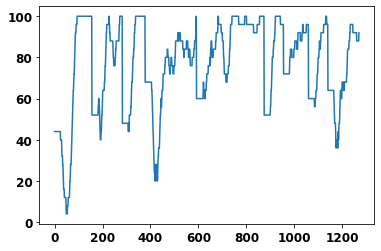

In [405]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)
learned = np.argwhere(m_performance>75).flatten()
unlearned = np.argwhere(m_performance<65).flatten()
print(learned.shape, unlearned.shape)

In [406]:
rule = np.zeros(np.size(X_rates,0))
for i in range(len(rule)):
    if (target[i]=='UU'):
        if (color[i] == 'r'):
            rule[i]=0
        elif(color[i] == 'g'):
            rule[i]=1
        else:
            rule[i]=2
    elif (target[i]=='UR'):
        if (color[i] == 'r'):
            rule[i]=3
        elif(color[i] == 'g'):
            rule[i]=4
        else:
            rule[i]=5
    elif (target[i]=='RR'):
        if (color[i] == 'r'):
            rule[i]=6
        elif(color[i] == 'g'):
            rule[i]=7
        else:
            rule[i]=8
    elif (target[i]=='DR'):
        if (color[i] == 'r'):
            rule[i]=9
        elif(color[i] == 'g'):
            rule[i]=10
        else:
            rule[i]=11
    elif (target[i]=='DD'):
        if (color[i] == 'r'):
            rule[i]=12
        elif(color[i] == 'g'):
            rule[i]=13
        else:
            rule[i]=14
    elif (target[i]=='DL'):
        if (color[i] == 'r'):
            rule[i]=15
        elif(color[i] == 'g'):
            rule[i]=16
        else:
            rule[i]=17
    elif (target[i]=='LL'):
        if (color[i] == 'r'):
            rule[i]=18
        elif(color[i] == 'g'):
            rule[i]=19
        else:
            rule[i]=20
    elif (target[i]=='UL'):
        if (color[i] == 'r'):
            rule[i]=21
        elif(color[i] == 'g'):
            rule[i]=22
        else:
            rule[i]=23
rule = rule.astype(int)
# print(np.unique(rule, return_counts=True))
print(f'Unlearned: {np.unique(rule[unlearned], return_counts=True)}')
print(f'Learned: {np.unique(rule[learned], return_counts=True)}')

Unlearned: (array([ 0,  1,  2,  3,  4,  7,  9, 10, 12, 13, 15, 17, 18, 23]), array([20,  1, 63, 29, 41, 15, 27,  1,  3, 66, 14, 54, 26, 26],
      dtype=int64))
Learned: (array([ 0,  2,  3,  4,  7,  9, 10, 12, 13, 15, 17, 18, 23]), array([ 28,  62,  26,  90, 112,  34,  37,   4,  83,  20,  81, 100,  80],
      dtype=int64))


In [ ]:
cor = np.array(np.where(outcome==0)).flatten()
icor = np.array(np.where(outcome==9)).flatten()
c_l = []
ic_ul = []
for c in cor:
    if c in learned:
        c_l.append(c)
for ic in icor:
    if ic in unlearned:
        ic_ul.append(ic)
print(np.unique(rule[c_l], return_counts=True))
print(np.unique(rule[ic_ul], return_counts=True))

In [447]:
rule1 = 18
rule2 = 17

In [448]:
rl = np.array(np.where((rule==rule1)|(rule==rule2))).flatten()
l_rl = []
ul_rl = []
for r in rl:
    if r in learned:
        l_rl.append(r)
    elif r in unlearned:
        ul_rl.append(r)
print(np.unique(color[l_rl], return_counts=True))
print(np.unique(color[ul_rl], return_counts=True))

# rl = np.array(np.where((rule==rule1)|(rule==rule2))).flatten()
# l_rl = []
# ul_rl = []
# for r in rl:
#     if r in c_l:
#         l_rl.append(r)
#     elif r in ic_ul:
#         ul_rl.append(r)
# print(np.unique(color[l_rl], return_counts=True))
# print(np.unique(color[ul_rl], return_counts=True))

(array(['b', 'r'], dtype=object), array([ 81, 100], dtype=int64))
(array(['b', 'r'], dtype=object), array([54, 26], dtype=int64))


In [449]:
tmp = rule[l_rl]
_y_l = np.zeros_like(tmp)
for i in range(len(tmp)):
    if (tmp[i]==rule2):
        _y_l[i]=1
tmp = rule[ul_rl]
_y_ul = np.zeros_like(tmp)
for i in range(len(tmp)):
    if (tmp[i]==rule2):
        _y_ul[i]=1

In [410]:
times

array([-0.6 , -0.59, -0.58, -0.57, -0.56, -0.55, -0.54, -0.53, -0.52,
       -0.51, -0.5 , -0.49, -0.48, -0.47, -0.46, -0.45, -0.44, -0.43,
       -0.42, -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34,
       -0.33, -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25,
       -0.24, -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16,
       -0.15, -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07,
       -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,
        0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,  0.1 ,  0.11,
        0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,  0.19,  0.2 ,
        0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0.27,  0.28,  0.29,
        0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,  0.36,  0.37,  0.38,
        0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,  0.46,  0.47,
        0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,  0.54,  0.55,  0.56,
        0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,  0.63,  0.64,  0.65,
        0.66,  0.67,

In [304]:
sep_score_l_j50 = []
sep_score_ul_j50 = []

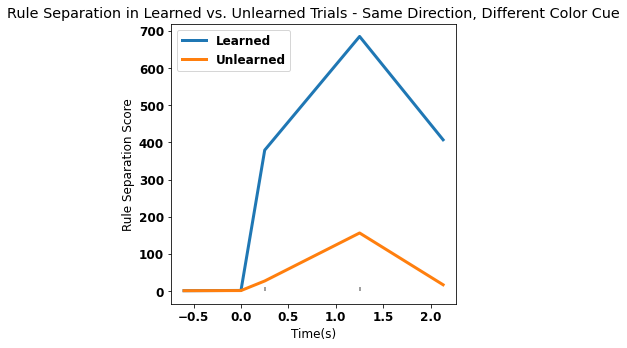

In [450]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

step = 20
windows=[0, np.argwhere(times==0)[0][0], np.argwhere(times==0.25)[0][0], np.argwhere(times==1.25)[0][0], len(times)-1]
length = len(windows)

_X = np.transpose(X_rates, (0, 2, 1))
# _X = X_rates


TEST_PERPLEXITY = [10]
# for rep in range(92):
X = _X[l_rl]

traj_l = np.zeros((X.shape[0], length, 2))

pca = PCA(n_components=16)
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY[-1])
for t in np.arange(1,length):
    a = 1
    if t==3: a=2
    tmp = X[:, windows[t-a]:windows[t], :]
    pca_values = pca.fit_transform(tmp.reshape([-1, np.prod(tmp.shape[1:])]))
    traj_l[:,t,:] = tsne_model.fit_transform(pca_values)

X = _X[ul_rl]
traj_ul = np.zeros((X.shape[0], length, 2))

pca = PCA(n_components=16)
tsne_model = TSNE(n_components=2, perplexity=TEST_PERPLEXITY[-1])
for t in np.arange(1,length):
    a = 1
    if t==3: a=2
    tmp = X[:, windows[t-a]:windows[t], :]
    pca_values = pca.fit_transform(tmp.reshape([-1, np.prod(tmp.shape[1:])]))
    traj_ul[:,t,:] = tsne_model.fit_transform(pca_values)    
from sklearn.metrics.cluster import calinski_harabasz_score as chs
font = {'weight'   : 'bold',
       'size': 12}

matplotlib.rc('font', **font)
score_l = np.zeros(traj_l.shape[1])
score_ul = np.zeros(traj_ul.shape[1])
for i in range(len(score_l)):
    score_l[i] = chs(np.squeeze(traj_l[:,i,:]), _y_l)
    score_ul[i] = chs(np.squeeze(traj_ul[:,i,:]), _y_ul)
#     sep_score_l_j50.append(score_l)
#     sep_score_ul_j50.append(score_ul)
fig = plt.figure(figsize=(5,5))
t = times[windows]
plt.plot(t, score_l, lw=3,label='Learned')
plt.plot(t, score_ul, lw=3,label='Unlearned')
plt.vlines(0, 0, 10, ls='dashed', color='grey')
plt.vlines(0.25, 0, 10, ls='dashed', color='grey')
plt.vlines(1.25, 0, 10, ls='dashed', color='grey')
plt.title('Rule Separation in Learned vs. Unlearned Trials - Same Direction, Different Color Cue')
plt.xlabel('Time(s)')
plt.ylabel('Rule Separation Score')
plt.legend()
plt.tight_layout()
plt.show()

In [318]:
sep_score_l_j50.append(score_l)
sep_score_ul_j50.append(score_ul)

In [322]:
with open('sep_score_l_j50.pkl', 'wb') as f:
    pickle.dump(sep_score_l_j50, f)
with open('sep_score_ul_j50.pkl', 'wb') as f:
    pickle.dump(sep_score_ul_j50, f)

In [4]:
with open('sep_score_l_m74.pkl', 'rb') as f:
    sep_score_l = pickle.load(f)
with open('sep_score_ul_m74.pkl', 'rb') as f:
    sep_score_ul = pickle.load(f)

In [8]:
print(len(sep_score_l), sep_score_l[0].shape)

100 (5,)


In [17]:
r_l = np.array(sep_score_l)[:,3]
r_ul = np.array(sep_score_ul)[:,3]

In [18]:
print(stats.kruskal(r_l,r_ul), stats.ranksums(r_l,r_ul))

KruskalResult(statistic=149.25395522981358, pvalue=2.523655033546687e-34) RanksumsResult(statistic=12.216944435630522, pvalue=2.5239394239903128e-34)


In [282]:
sep_score_l

[array([ 1.        ,  4.43188253, 73.73203191, 96.04285394, 49.05110294]),
 array([ 1.        ,  0.19146144, 66.82873287, 77.95601446, 48.31304272]),
 array([ 1.        ,  2.11983496, 75.76790443, 95.69349739, 58.63826048]),
 array([ 1.        ,  4.0702653 , 69.62218584, 93.55124152, 52.65555044]),
 array([ 1.        ,  1.04521574, 54.53798542, 64.29875518, 44.64567002]),
 array([ 1.        ,  1.1243325 , 61.47677201, 83.54300078, 63.55509637]),
 array([1.00000000e+00, 3.43985353e-03, 5.29723892e+01, 7.67359556e+01,
        6.02510815e+01]),
 array([ 1.        ,  2.13277848, 59.72479332, 78.30036111, 52.7594398 ]),
 array([ 1.        ,  6.27758047, 34.21428571, 78.66650972, 62.47919038]),
 array([ 1.        ,  6.09862224, 68.45035277, 66.72736183, 55.61103004]),
 array([ 1.        ,  3.20907126, 47.76191855, 61.1146154 , 60.28216644]),
 array([ 1.        ,  1.44722019, 72.63201851, 76.32306586, 65.61334845]),
 array([ 1.        ,  1.88856234, 63.9203411 , 59.13762752, 50.52706686]),
 a

# Saccade Decoding

In [16]:
load_kwargs = {
    'valid_outcomes': (0, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.45),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
accs = np.zeros((8, 4, 20)) # Session X Methods X Runs (Methods Order: DNN, RF, SVM, LLR)
accs_shuf = np.zeros((8, 4, 20)) # Session X Methods X Runs (Methods Order: DNN, RF, SVM, LLR)
verbose=0
N_SPLITS = 5
EPOCHS = 100
for sess in range(8):
    print(f'Sess: {sess}')
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    print(f"\nImporting session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs)
    X_rates = np.transpose(X_rates, (0, 2, 1))
    Y_class = Y.ravel()
    Y_shuf = np.random.permutation(Y_class)
    svm_folds=[]
    llr_folds=[]
    rf_folds=[]
    dnn_folds=[]
    true_folds=[]
    svm_shuf=[]
    llr_shuf=[]
    rf_shuf=[]
    dnn_shuf=[]
    fold_shuf=[]
    for rep in range(20):
        splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
        split_ix = 0
        print(f'Run: {rep}')
        for trn, vld in splitter.split(X_rates, Y_class):
            print(f"\tSplit {split_ix + 1} of {N_SPLITS}")
            _y = tf.keras.utils.to_categorical(Y_class, num_classes=8)
            _y_shuf = tf.keras.utils.to_categorical(Y_shuf, num_classes=8)
            x_flat_trn = np.reshape(X_rates[trn], (X_rates[trn].shape[0], -1))
            x_flat_vld = np.reshape(X_rates[vld], (X_rates[vld].shape[0], -1))
            ds_train = tf.data.Dataset.from_tensor_slices((X_rates[trn], _y[trn]))
            ds_valid = tf.data.Dataset.from_tensor_slices((X_rates[vld], _y[vld]))

            # cast data types to GPU-friendly types.
            ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
            ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

            # TODO: augmentations (random slicing?)

            ds_train = ds_train.shuffle(len(trn) + 1)
            ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
            ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

            ds_train_shuf = tf.data.Dataset.from_tensor_slices((X_rates[trn], _y_shuf[trn]))
            ds_valid_shuf = tf.data.Dataset.from_tensor_slices((X_rates[vld], _y_shuf[vld]))

            # cast data types to GPU-friendly types.
            ds_train_shuf = ds_train_shuf.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
            ds_valid_shuf = ds_valid_shuf.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

            # TODO: augmentations (random slicing?)

            ds_train_shuf = ds_train_shuf.shuffle(len(trn) + 1)
            ds_train_shuf = ds_train_shuf.batch(BATCH_SIZE, drop_remainder=True)
            ds_valid_shuf = ds_valid_shuf.batch(BATCH_SIZE, drop_remainder=False)

            tf.keras.backend.clear_session()

#             randseed = 12345
#             random.seed(randseed)
#             np.random.seed(randseed)
#             tf.random.set_seed(randseed)

            model = make_model(X_rates, _y.shape[-1])
            optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
            loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
            model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

            best_model_path = f'r2s_{sess_id}_split{split_ix}.h5'
            callbacks = [
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=best_model_path,
                    # Path where to save the model
                    # The two parameters below mean that we will overwrite
                    # the current checkpoint if and only if
                    # the `val_loss` score has improved.
                    save_best_only=True,
                    monitor='val_accuracy',
                    verbose=verbose)
            ]

            hist = model.fit(x=ds_train, epochs=EPOCHS,
                             verbose=verbose,
                             validation_data=ds_valid,
                             callbacks=callbacks)


            #RF
            clf = RandomForestClassifier(max_depth=6, random_state=0).fit(x_flat_trn, Y_class[trn])
            rf_folds.append(clf.predict(x_flat_vld))
            #SVM
            clf = SVC(verbose=verbose).fit(x_flat_trn, Y_class[trn])
            svm_folds.append(clf.predict(x_flat_vld))
            #LLR
            clf = LR(random_state=0, verbose=verbose).fit(x_flat_trn, Y_class[trn])
            llr_folds.append(clf.predict(x_flat_vld))
            #DNN
            model = tf.keras.models.load_model(best_model_path)
            dnn_folds.append(model(X_rates[vld]).numpy())
            true_folds.append(Y_class[vld])

            model = make_model(X_rates, _y_shuf.shape[-1])
            optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
            loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
            model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

            model.fit(x=ds_train_shuf, epochs=10,verbose=verbose)
            #RF
            clf = RandomForestClassifier(max_depth=6, random_state=0).fit(x_flat_trn, Y_shuf[trn])
            rf_shuf.append(clf.predict(x_flat_vld))
            #SVM
            clf = SVC(verbose=verbose).fit(x_flat_trn, Y_shuf[trn])
            svm_shuf.append(clf.predict(x_flat_vld))
            #LLR
            clf = LR(solver='liblinear', random_state=0, verbose=verbose).fit(x_flat_trn, Y_shuf[trn])
            llr_shuf.append(clf.predict(x_flat_vld))
            #DNN
            dnn_shuf.append(model(X_rates[vld]).numpy())
            fold_shuf.append(Y_shuf[vld])
            split_ix += 1
        pred_y = np.concatenate([np.argmax(_, axis=1) for _ in dnn_folds])
        true_y = np.concatenate(true_folds).flatten()
        accs[sess, 0, rep] =  100 * np.sum(pred_y == true_y) / len(pred_y)# DNN
        print(f'DNN: {accs[sess, 0, rep]}')
        pred_y = np.concatenate([_ for _ in rf_folds])
        accs[sess, 1, rep] =  100 * np.sum(pred_y == true_y) / len(pred_y)# RF
        print(f'RF: {accs[sess, 1, rep]}')
        pred_y = np.concatenate([_ for _ in svm_folds])
        accs[sess, 2, rep] =  100 * np.sum(pred_y == true_y) / len(pred_y)# SVM
        print(f'SVM: {accs[sess, 2, rep]}')
        pred_y = np.concatenate([_ for _ in llr_folds])
        accs[sess, 3, rep] =  100 * np.sum(pred_y == true_y) / len(pred_y)# LLR
        print(f'LLR: {accs[sess, 3, rep]}')
        pred_y = np.concatenate([np.argmax(_, axis=1) for _ in dnn_shuf])
        true_y = np.concatenate(fold_shuf).flatten()
        accs_shuf[sess, 0, rep] =  100 * np.sum(pred_y == true_y) / len(pred_y)# DNN
        print(f'DNN_Chance: {accs_shuf[sess, 0, rep]}')
        pred_y = np.concatenate([_ for _ in rf_shuf])
        accs_shuf[sess, 1, rep] =  100 * np.sum(pred_y == true_y) / len(pred_y)# RF
        print(f'RF_Chance: {accs_shuf[sess, 1, rep]}')
        pred_y = np.concatenate([_ for _ in svm_shuf])
        accs_shuf[sess, 2, rep] =  100 * np.sum(pred_y == true_y) / len(pred_y)# SVM
        print(f'SVM_Chance: {accs_shuf[sess, 2, rep]}')
        pred_y = np.concatenate([_ for _ in llr_shuf])
        accs_shuf[sess, 3, rep] =  100 * np.sum(pred_y == true_y) / len(pred_y)# LLR
        print(f'LLR_Chance: {accs_shuf[sess, 3, rep]}')

Sess: 0

Importing session sra3_2_j_037_00+03
Run: 0
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.4113475177305
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 48.93617021276596
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 1
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 64.00709219858156
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 49.290780141843975
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 2
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 63.002364066193856
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 47.75413711583924
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 3
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 63.03191489361702
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 48.226950354609926
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 4
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 63.12056737588652
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 48.226950354609926
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 5
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.88416075650118
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 47.28132387706856
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 6
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.71529888551165
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 47.41641337386018
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 7
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.72163120567376
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 47.20744680851064
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 8
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.56895193065406
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 47.5177304964539
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 9
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.5886524822695
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 47.801418439716315
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 10
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.54029658284978
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 47.5177304964539
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 11
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.5
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 47.4290780141844
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 12
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.49318057828696
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 47.54500818330605
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 13
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.68996960486322
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 47.74569402228977
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 14
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.600472813238774
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 48.274231678487
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 15
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.566489361702125
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 48.315602836879435
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 16
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.55736337088027
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 48.226950354609926
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 17
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.5886524822695
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 48.089046493301815
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 18
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.523329600597236
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 47.92833146696528
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Run: 19
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.695035460992905
RF: 54.60992907801418
SVM: 56.02836879432624
LLR: 51.06382978723404
DNN_Chance: 48.08510638297872
RF_Chance: 55.673758865248224
SVM_Chance: 52.4822695035461
LLR_Chance: 51.06382978723404
Sess: 1

Importing session sra3_1_j_050_00+
Run: 0
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 73.57357357357357
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.063063063063064
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 1
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.09909909909909
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.73873873873874
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 2
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.32432432432432
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.363363363363364
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 3
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.06156156156156
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.25075075075075
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 4
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.14414414414415
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.423423423423424
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 5
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.22422422422423
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.488488488488489
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 6
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.19562419562419
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.5993135993136
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 7
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.30555555555556
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.532282282282281
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 8
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.34100767434101
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.430096763430097
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 9
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.29429429429429
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.513513513513514
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 10
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.41987441987442
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.4998634998635
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 11
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.42442442442443
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.475975975975976
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 12
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.43982443982443
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.398013398013399
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 13
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.47447447447448
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.32046332046332
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 14
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.41441441441441
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.263263263263264
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 15
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.44632132132132
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.344594594594595
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 16
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.40381558028616
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.372195725136901
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 17
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.41608274941608
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.438438438438439
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 18
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.37174016121385
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.34755808440019
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Run: 19
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.36936936936937
RF: 72.97297297297297
SVM: 72.97297297297297
LLR: 72.37237237237237
DNN_Chance: 13.43093093093093
RF_Chance: 16.366366366366368
SVM_Chance: 12.612612612612613
LLR_Chance: 12.012012012012011
Sess: 2

Importing session sra3_1_j_051_00+
Run: 0
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.14084507042253
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 24.507042253521128
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 1
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.91549295774648
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 26.408450704225352
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 2
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 71.26760563380282
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 25.492957746478872
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 3
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 71.51408450704226
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 26.056338028169016
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 4
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 71.69014084507042
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 26.140845070422536
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 5
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 71.54929577464789
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 26.150234741784036
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 6
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 71.7102615694165
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 26.519114688128774
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 7
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 71.63732394366197
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 26.426056338028168
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 8
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 71.78403755868544
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 26.21283255086072
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 9
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 71.88732394366197
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 26.098591549295776
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 10
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 72.0358514724712
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 25.96670934699104
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 11
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 71.96009389671362
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 25.997652582159624
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 12
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 71.98266522210184
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 25.947995666305527
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 13
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 71.98189134808852
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 26.036217303822937
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 14
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 71.94366197183099
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 25.92488262910798
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 15
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 72.00704225352112
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 25.783450704225352
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 16
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 72.06296603148301
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 25.79950289975145
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 17
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 72.03442879499218
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 25.672926447574334
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 18
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 72.07561156412157
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 25.737583395107485
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Run: 19
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 72.1056338028169
RF: 69.5774647887324
SVM: 65.49295774647888
LLR: 64.22535211267606
DNN_Chance: 25.774647887323944
RF_Chance: 24.366197183098592
SVM_Chance: 25.774647887323944
LLR_Chance: 26.47887323943662
Sess: 3

Importing session sra3_1_j_052_00+
Run: 0
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 61.60458452722063
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 18.19484240687679
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 1
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.673352435530084
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 16.7621776504298
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 2
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.55396370582617
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 16.284622731614135
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 3
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.56590257879656
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 16.69054441260745
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 4
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.77363896848138
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 17.191977077363898
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 5
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.88825214899713
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 16.809933142311365
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 6
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.84731887024151
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 16.4756446991404
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 7
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.88825214899713
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 16.171203438395416
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 8
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.80865966252786
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 16.15727475326329
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 9
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.83094555873925
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 16.174785100286535
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 10
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.666840323000784
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 16.189111747851
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 11
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.69723018147087
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 16.16523400191022
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 12
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.68988318271986
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 16.22217324223055
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 13
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.75521899304134
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 16.137945149406466
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 14
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.678127984718245
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 16.236867239732568
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 15
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.73603151862464
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 16.20702005730659
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 16
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.76184055284005
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 16.104837350412943
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 17
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.792741165234
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 16.09360076408787
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 18
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.73744533252903
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 15.993062886442468
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Run: 19
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.759312320916905
RF: 59.31232091690544
SVM: 55.01432664756447
LLR: 51.71919770773639
DNN_Chance: 15.959885386819485
RF_Chance: 20.200573065902578
SVM_Chance: 17.191977077363898
LLR_Chance: 17.335243553008596
Sess: 4

Importing session sra3_1_m_077_00+01
Run: 0
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 34.7953216374269
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 19.005847953216374
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 1
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.89473684210526
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 17.690058479532162
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 2
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 33.62573099415204
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 17.64132553606238
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 3
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 33.04093567251462
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 17.690058479532162
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 4
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 33.099415204678365
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 17.54385964912281
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 5
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 33.04093567251462
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 17.54385964912281
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 6
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.87385129490393
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 17.54385964912281
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 7
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.711988304093566
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 17.83625730994152
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 8
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.683560753736195
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 17.83625730994152
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 9
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.77777777777778
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 18.216374269005847
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 10
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.589048378522065
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 18.28814460393408
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 11
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.60233918128655
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 18.323586744639375
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 12
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.59109311740891
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 18.30859199280252
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 13
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.72765246449457
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 18.128654970760234
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 14
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.92397660818713
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 18.226120857699804
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 15
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 33.00438596491228
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 17.982456140350877
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 16
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.92053663570692
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 18.04265565875473
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 17
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.9759584145549
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 18.014944769330736
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 18
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.91782086795937
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 18.097876269621423
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Run: 19
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.93859649122807
RF: 32.16374269005848
SVM: 39.1812865497076
LLR: 33.62573099415204
DNN_Chance: 18.14327485380117
RF_Chance: 19.005847953216374
SVM_Chance: 20.17543859649123
LLR_Chance: 15.2046783625731
Sess: 5

Importing session sra3_1_m_081_00+01
Run: 0
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.32057416267943
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 22.248803827751196
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 1
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.483253588516746
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 21.172248803827753
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 2
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 35.80542264752791
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 20.574162679425836
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 3
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 35.645933014354064
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 20.69377990430622
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 4
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 35.78947368421053
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 20.76555023923445
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 5
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 35.96491228070175
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 21.09250398724083
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 6
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.05604921394395
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 20.915926179084074
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 7
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.06459330143541
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 20.992822966507177
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 8
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.04465709728868
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 20.893141945773525
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 9
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.411483253588514
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 20.789473684210527
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 10
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.38538494997825
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 21.096128751631145
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 11
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.36363636363637
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 21.21212121212121
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 12
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.418844313581154
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 21.126242178873756
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 13
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.60287081339713
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 21.06971975393028
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 14
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.60287081339713
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 21.3237639553429
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 15
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.63277511961722
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 21.217105263157894
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 16
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.7013791162398
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 21.249648184632704
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 17
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.921850079744814
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 21.26528442317916
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 18
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.95542684462352
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 21.266683455049105
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Run: 19
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.9377990430622
RF: 44.49760765550239
SVM: 45.21531100478469
LLR: 40.90909090909091
DNN_Chance: 21.279904306220097
RF_Chance: 18.42105263157895
SVM_Chance: 14.832535885167465
LLR_Chance: 17.464114832535884
Sess: 6

Importing session sra3_1_m_082_00+01
Run: 0
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 72.5
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 29.285714285714285
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 1
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 71.25
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 27.5
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 2
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.71428571428571
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 29.047619047619047
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 3
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.625
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 27.946428571428573
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 4
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.57142857142857
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 27.5
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 5
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.5952380952381
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 26.964285714285715
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 6
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.76530612244898
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 26.785714285714285
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 7
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.75892857142857
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 26.785714285714285
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 8
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.55555555555556
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 26.547619047619047
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 9
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.46428571428571
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 26.642857142857142
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 10
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.55194805194805
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 26.655844155844157
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 11
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.5952380952381
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 26.636904761904763
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 12
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.49450549450549
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 26.703296703296704
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 13
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.61224489795919
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 26.785714285714285
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 14
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.61904761904762
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 26.571428571428573
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 15
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.49107142857143
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 26.5625
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 16
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.48319327731092
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 26.701680672268907
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 17
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.57539682539682
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 26.865079365079364
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 18
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.56390977443608
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 26.860902255639097
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Run: 19
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.60714285714286
RF: 68.21428571428571
SVM: 69.28571428571429
LLR: 69.64285714285714
DNN_Chance: 26.928571428571427
RF_Chance: 26.071428571428573
SVM_Chance: 31.785714285714285
LLR_Chance: 23.928571428571427
Sess: 7

Importing session sra3_1_m_083_00+01
Run: 0
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.477987421383645
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 17.29559748427673
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 1
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.106918238993714
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 16.19496855345912
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 2
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.687631027253666
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 16.561844863731658
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 3
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.9496855345912
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 16.90251572327044
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 4
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.0440251572327
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 16.729559748427672
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 5
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.264150943396224
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 16.9811320754717
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 6
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.106918238993714
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 17.07097933513028
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 7
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.382075471698116
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 17.21698113207547
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 8
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.526205450733755
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 17.435359888190078
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 9
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.735849056603776
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 17.42138364779874
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 10
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.62149799885649
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 17.524299599771297
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 11
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.5524109014675
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 17.557651991614257
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 12
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.32462506047412
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 17.513304305757135
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 13
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.331536388140165
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 17.61006289308176
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 14
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.37945492662474
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 17.77777777777778
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 15
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.460691823899374
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 17.78694968553459
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 16
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.62486126526082
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 17.647058823529413
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 17
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.526205450733755
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 17.697414395527602
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 18
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.47103608076796
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 17.759020191989407
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176
Run: 19
	Split 1 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 2 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 3 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 4 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Split 5 of 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.42138364779874
RF: 51.257861635220124
SVM: 51.57232704402516
LLR: 50.943396226415096
DNN_Chance: 17.751572327044027
RF_Chance: 16.9811320754717
SVM_Chance: 17.61006289308176
LLR_Chance: 17.61006289308176


In [17]:
# Methods Order: DNN - RF - SVM - LLR
# Session X Method X Runs

with open('accs_r2s.pkl', 'wb') as f:
    pickle.dump(accs, f)
with open('accs_r2s_chance.pkl', 'wb') as f:
    pickle.dump(accs_shuf, f)

In [3]:
with open('accs_r2s.pkl', 'rb') as f:
    accs = np.array(pickle.load(f))
with open('accs_r2s_chance.pkl', 'rb') as f:
    accs_shuf = np.array(pickle.load(f))

In [35]:
for sess in range(8):
    print(f'Session: {sess}')
    acc = accs[sess,0]
    chance = accs_shuf[sess,0]
    print(stats.kruskal(acc,chance), stats.ranksums(acc,chance))

Session: 0
KruskalResult(statistic=29.284775671109454, pvalue=6.248469412580822e-08) RanksumsResult(statistic=5.410017808004594, pvalue=6.301848221392269e-08)
Session: 1
KruskalResult(statistic=29.26829268292684, pvalue=6.301848221392254e-08) RanksumsResult(statistic=5.410017808004594, pvalue=6.301848221392269e-08)
Session: 2
KruskalResult(statistic=29.26829268292684, pvalue=6.301848221392254e-08) RanksumsResult(statistic=5.410017808004594, pvalue=6.301848221392269e-08)
Session: 3
KruskalResult(statistic=29.271038558964268, pvalue=6.292924314800097e-08) RanksumsResult(statistic=5.410017808004594, pvalue=6.301848221392269e-08)
Session: 4
KruskalResult(statistic=29.287524640946227, pvalue=6.23961127889831e-08) RanksumsResult(statistic=5.410017808004594, pvalue=6.301848221392269e-08)
Session: 5
KruskalResult(statistic=29.271038558964268, pvalue=6.292924314800097e-08) RanksumsResult(statistic=5.410017808004594, pvalue=6.301848221392269e-08)
Session: 6
KruskalResult(statistic=29.28477567110

In [7]:
err_dnn = np.zeros(8)
err_rf = np.zeros(8)
err_svm = np.zeros(8)
err_rlr = np.zeros(8)
for i in range(8):
    err_dnn[i] = np.var(accs[i,0,:])
    err_rf[i] = np.var(accs[i,1,:])
    err_svm[i] = np.var(accs[i,2,:])
    err_rlr[i] = np.var(accs[i,3,:])

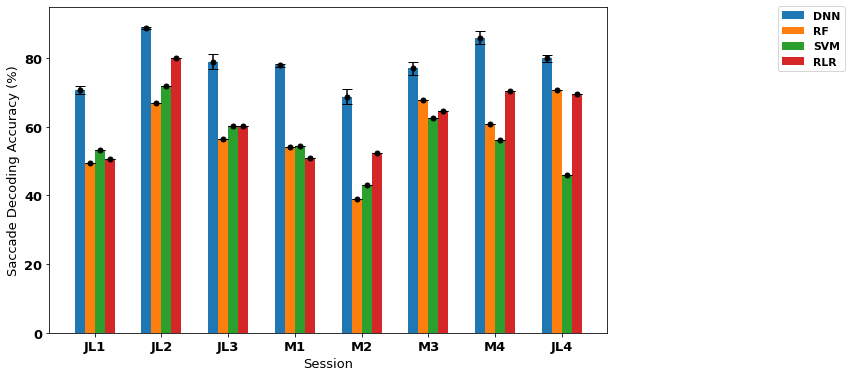

In [9]:
import matplotlib
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

sessions = ['JL1', 'JL2', 'JL3', 'M1', 'M2', 'M3', 'M4', 'JL4']
x = np.arange(0, 2*len(sessions), 2)  # the label locations
width = 0.3

dnn = np.array([70.625, 88.7719298245614, 78.96678966789668,
               77.9783393501805, 68.75, 77.08333333333333, 85.9375, 80.0])
rf = np.array([49.375, 67.01754385964912, 56.457564575645755, 54.151624548736464,
               39.0625, 67.70833333333333, 60.9375, 70.58823529411765])
rlr = np.array([50.625, 80.0, 60.14760147601476, 50.90252707581227,
                52.34375, 64.58333333333333, 70.3125, 69.41176470588235])
svm = np.array([53.125, 71.9298245614035, 60.14760147601476, 54.51263537906137,
                42.96875, 62.5, 56.25, 45.88235294117647])

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - 3*width/2, dnn, width, label='DNN')
plt.errorbar(x - 3*width/2, dnn, yerr=err_dnn, fmt='.', markersize='10', capsize=5, color='black')
rects2 = ax.bar(x - width/2, rf, width, label='RF')
plt.errorbar(x - width/2, rf, yerr=err_rf, fmt='.', markersize='10', capsize=5, color='black')
rects4 = ax.bar(x + width/2, svm, width, label='SVM')
plt.errorbar(x + width/2, svm, yerr=err_svm, fmt='.', markersize='10', capsize=5, color='black')
rects3 = ax.bar(x + 3*width/2, rlr, width, label='RLR')
plt.errorbar(x + 3*width/2, rlr, yerr=err_rlr, fmt='.', markersize='10', capsize=5, color='black')

ax.set_ylim([0, 95])
ax.set_ylabel('Saccade Decoding Accuracy (%)')
ax.set_xlabel('Session')
ax.set_xticks(x)
ax.set_xticklabels(sessions)
ax.legend(loc='lower right', bbox_to_anchor=(1.435, .785), fontsize='small')
fig.savefig("performance.svg")
# fig.tight_layout()
plt.show()

# Rule Decoding

In [19]:
# sess_infos.append ({'name': 'Marty',
#                  'bank': 'A',
#                  'name_short': 'm',
#                  'date': '',
#                  'exp_code': 'sra3_1_m_074_00+01',
#                  'nsx': ''})

In [21]:
for s_idx in range(9):
    X,_,_,_ = load_session(s_idx)
    print(X.shape)

(332, 32, 207)
(663, 32, 207)
(681, 32, 207)
(695, 32, 207)
(311, 32, 207)
(307, 32, 207)
(251, 32, 207)
(289, 32, 207)
(1305, 32, 166)


In [18]:
def load_session(s_idx):
    sess_info = sess_infos[s_idx]
    sess_id = sess_info['exp_code']
    sess_id = sess_id.replace("+", "")+"_v1" + "_segmented.h5"
    segmented_path = data_path / sess_id
    segmented_data = from_neuropype_h5(segmented_path)
    outcome = np.array(segmented_data[2][1]['axes'][0]['data']['OutcomeCode'])
    flag = np.argwhere(outcome>-1).flatten()
    outcome = outcome[flag]
    Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()[flag]
    Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
    X_rates = segmented_data[2][1]['data'][flag]
    X_rates = np.nan_to_num(X_rates)
    X_rates = np.transpose(X_rates, (0, 2, 1))
    block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()[flag]
    b=np.diff(block, axis=0)
    border=np.array(np.where(b>0)).flatten()
    to_keep = [0]
    for i in range(len(border) - 1):
        if (border[i + 1] - border[i]) > 30 and (len(outcome)-border[i+1]) > 30:
            to_keep.append(i + 1)
    border = border[to_keep]
    color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()[flag]
    target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()[flag]
    classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()[flag]
    times = np.array(segmented_data[2][1]['axes'][1]['times']).flatten()
    rule = np.zeros(np.size(X_rates,0))
    for i in range(len(rule)):
        if (target[i]=='UU'):
            if (color[i] == 'r'):
                rule[i]=0
            elif(color[i] == 'g'):
                rule[i]=1
            else:
                rule[i]=2
        elif (target[i]=='UR'):
            if (color[i] == 'r'):
                rule[i]=3
            elif(color[i] == 'g'):
                rule[i]=4
            else:
                rule[i]=5
        elif (target[i]=='RR'):
            if (color[i] == 'r'):
                rule[i]=6
            elif(color[i] == 'g'):
                rule[i]=7
            else:
                rule[i]=8
        elif (target[i]=='DR'):
            if (color[i] == 'r'):
                rule[i]=9
            elif(color[i] == 'g'):
                rule[i]=10
            else:
                rule[i]=11
        elif (target[i]=='DD'):
            if (color[i] == 'r'):
                rule[i]=12
            elif(color[i] == 'g'):
                rule[i]=13
            else:
                rule[i]=14
        elif (target[i]=='DL'):
            if (color[i] == 'r'):
                rule[i]=15
            elif(color[i] == 'g'):
                rule[i]=16
            else:
                rule[i]=17
        elif (target[i]=='LL'):
            if (color[i] == 'r'):
                rule[i]=18
            elif(color[i] == 'g'):
                rule[i]=19
            else:
                rule[i]=20
        elif (target[i]=='UL'):
            if (color[i] == 'r'):
                rule[i]=21
            elif(color[i] == 'g'):
                rule[i]=22
            else:
                rule[i]=23
    rule = rule.astype(int)
    tmp = rule
    _yu = np.unique(rule)
    for i in range(len(tmp)):
        rule[i] = np.where(_yu == tmp[i])[0][0]
    
    m_performance = np.zeros(len(outcome))
    cor = 0
    b=0
    tot = 25
    for i in range(tot):
        if outcome[i]==0:
            cor += 1

    m_performance[:tot] = 100 * (cor / tot)
    # for i in range(tot, len(outcome)):
    i = tot
    while i<len(outcome):
        if i == border[b]:
            cor = 0
            for j in range(tot):
                if outcome[i+j]==0:
                    cor += 1
            m_performance[i:i+tot] = 100 * (cor / tot)
            i += tot
            b = (b+1)%len(border)
        elif outcome[i] == outcome[i-tot]:
            m_performance[i] = m_performance[i-1]
            i += 1
        elif outcome[i]==0:
            cor += 1
            m_performance[i] = 100 * (cor / tot)
            i += 1
        else:
            cor -= 1
            m_performance[i] = 100 * (cor / tot)
            i +=1

    for i in range(len(m_performance)):
        if m_performance[i]<0:
            m_performance[i] = 0
    learned = np.argwhere(m_performance>75).flatten()
    unlearned = np.argwhere(m_performance<65).flatten()
    
    return X_rates, rule, learned, unlearned

In [27]:
accs = np.zeros((9, 20)) # Session X Methods X Runs (Methods Order: DNN, RF, SVM, LLR)
accs_shuf = np.zeros((9, 20)) # Session X Methods X Runs (Methods Order: DNN, RF, SVM, LLR)
verbose=0
N_SPLITS = 10
EPOCHS = 100
for sess in range(9):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    print(f"\nImporting session {sess_id}")
    X_rates, rule, learned, unlearned = load_session(sess)
    X_rates = X_rates[learned]
    Y_class = rule[learned]
    tmp = Y_class
    _yu = np.unique(Y_class)
    for i in range(len(tmp)):
        Y_class[i] = np.where(_yu == tmp[i])[0][0]
    Y_shuf = np.random.permutation(Y_class)
    dnn_folds=[]
    true_folds=[]
    dnn_shuf=[]
    fold_shuf=[]
    for rep in range(20):
        print(f'\nRun: {rep}')
        _, accs[sess, rep], _, _ = kfold_pred(sess_id,X_rates,Y_class,name=f'r2r_{rep}', verbose=verbose)
        print('Chance')
        _, accs_shuf[sess, rep], _, _ = kfold_pred(sess_id,X_rates,Y_shuf,name=f'r2r_{rep}', verbose=verbose)


Importing session sra3_2_j_037_00+03

Run: 0
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 56.93069306930693%


Chance
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 57.42574257425743%



Run: 1
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 58.91089108910891%


Chance
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 54.45544554455446%



Run: 2
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 56.93069306930693%


Chance
	Split 

/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 79.44162436548223%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 24.365482233502537%



Run: 1
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 78.68020304568527%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 25.888324873096447%



Run: 2
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 78.42639593908629%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 23.85786802030457%



Run: 3
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 79.44162436548223%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 25.126903553299492%



Run: 4
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 79.44162436548223%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 26.395939086294415%



Run: 5
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 80.71065989847716%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 24.365482233502537%



Run: 6
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 79.18781725888324%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 23.85786802030457%



Run: 7
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 78.93401015228426%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 25.634517766497463%



Run: 8
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 78.68020304568527%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 25.634517766497463%



Run: 9
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 79.94923857868021%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 23.604060913705585%



Run: 10
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 79.18781725888324%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 24.365482233502537%



Run: 11
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 80.45685279187818%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 24.365482233502537%



Run: 12
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 78.68020304568527%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 24.111675126903553%



Run: 13
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 78.68020304568527%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 25.380710659898476%



Run: 14
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 81.47208121827411%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 24.619289340101524%



Run: 15
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 78.68020304568527%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 24.619289340101524%



Run: 16
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 80.96446700507614%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 24.365482233502537%



Run: 17
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 80.71065989847716%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 24.365482233502537%



Run: 18
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 79.44162436548223%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 24.365482233502537%



Run: 19
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 79.18781725888324%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 24.111675126903553%



Importing session sra3_1_j_051_00+

Run: 0
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 72.18045112781955%


Chance
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 25.06265664160401%



Run: 1
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 72.68170426065163%


Chance
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 25.06265664160401%



Run: 2
	Split 1 of 10
	Split 2 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 73.53951890034364%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 26.460481099656356%



Run: 1
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 74.5704467353952%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 26.116838487972508%



Run: 2
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 73.19587628865979%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 26.804123711340207%



Run: 3
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 73.19587628865979%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 25.42955326460481%



Run: 4
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 73.53951890034364%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 26.460481099656356%



Run: 5
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 75.94501718213058%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 26.460481099656356%



Run: 6
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 75.25773195876289%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 27.835051546391753%



Run: 7
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 73.53951890034364%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 25.77319587628866%



Run: 8
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 74.91408934707904%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 25.085910652920962%



Run: 9
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 73.53951890034364%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 25.77319587628866%



Run: 10
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 75.60137457044674%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 26.116838487972508%



Run: 11
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 75.94501718213058%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 26.460481099656356%



Run: 12
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 74.5704467353952%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 27.147766323024054%



Run: 13
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 73.88316151202748%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 26.804123711340207%



Run: 14
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 74.5704467353952%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 25.085910652920962%



Run: 15
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 74.22680412371135%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 26.804123711340207%



Run: 16
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 74.22680412371135%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 25.085910652920962%



Run: 17
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 73.88316151202748%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 26.116838487972508%



Run: 18
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 72.85223367697594%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 29.896907216494846%



Run: 19
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 73.19587628865979%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 25.77319587628866%



Importing session sra3_1_m_077_00+01

Run: 0
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 61.58940397350993%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 38.41059602649007%



Run: 1
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 62.25165562913907%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 41.05960264900662%



Run: 2
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 62.25165562913907%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 37.086092715231786%



Run: 3
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 62.25165562913907%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 37.74834437086093%



Run: 4
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 58.94039735099338%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 38.41059602649007%



Run: 5
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 62.913907284768214%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 37.74834437086093%



Run: 6
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 64.90066225165563%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 38.41059602649007%



Run: 7
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 62.25165562913907%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 40.397350993377486%



Run: 8
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 62.25165562913907%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 36.42384105960265%



Run: 9
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 62.913907284768214%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 37.74834437086093%



Run: 10
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 64.23841059602648%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 39.0728476821192%



Run: 11
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 61.58940397350993%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 41.05960264900662%



Run: 12
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 60.9271523178808%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 42.384105960264904%



Run: 13
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 62.913907284768214%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 37.74834437086093%



Run: 14
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 61.58940397350993%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 41.05960264900662%



Run: 15
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 64.90066225165563%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 37.74834437086093%



Run: 16
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 64.23841059602648%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 37.086092715231786%



Run: 17
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 62.25165562913907%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 35.76158940397351%



Run: 18
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 61.58940397350993%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 41.05960264900662%



Run: 19
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 62.913907284768214%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 39.0728476821192%



Importing session sra3_1_m_081_00+01

Run: 0
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 48.97959183673469%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 36.734693877551024%



Run: 1
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 47.61904761904762%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 38.775510204081634%



Run: 2
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 47.61904761904762%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 33.333333333333336%



Run: 3
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 49.65986394557823%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 36.054421768707485%



Run: 4
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 47.61904761904762%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 39.45578231292517%



Run: 5
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 50.34013605442177%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 38.095238095238095%



Run: 6
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 48.29931972789116%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 34.69387755102041%



Run: 7
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 48.97959183673469%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 36.734693877551024%



Run: 8
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 44.89795918367347%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 35.374149659863946%



Run: 9
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 49.65986394557823%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 38.095238095238095%



Run: 10
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 51.70068027210884%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 37.414965986394556%



Run: 11
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 48.97959183673469%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 35.374149659863946%



Run: 12
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 48.97959183673469%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 35.374149659863946%



Run: 13
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 48.97959183673469%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 36.734693877551024%



Run: 14
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 50.34013605442177%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 35.374149659863946%



Run: 15
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 48.97959183673469%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 38.775510204081634%



Run: 16
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 51.02040816326531%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 37.414965986394556%



Run: 17
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 50.34013605442177%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 36.054421768707485%



Run: 18
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 47.61904761904762%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 36.734693877551024%



Run: 19
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 49.65986394557823%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 37.414965986394556%



Importing session sra3_1_m_082_00+01

Run: 0
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 64.38356164383562%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 64.38356164383562%



Run: 1
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 69.86301369863014%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 61.64383561643836%



Run: 2
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 63.013698630136986%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 63.013698630136986%



Run: 3
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 69.86301369863014%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 58.9041095890411%



Run: 4
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 69.86301369863014%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 60.273972602739725%



Run: 5
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 65.75342465753425%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 65.75342465753425%



Run: 6
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 67.12328767123287%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 63.013698630136986%



Run: 7
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 65.75342465753425%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 60.273972602739725%



Run: 8
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 71.23287671232876%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 63.013698630136986%



Run: 9
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 71.23287671232876%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 61.64383561643836%



Run: 10
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 67.12328767123287%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 64.38356164383562%



Run: 11
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 71.23287671232876%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 61.64383561643836%



Run: 12
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 68.4931506849315%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 61.64383561643836%



Run: 13
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 69.86301369863014%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 61.64383561643836%



Run: 14
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 68.4931506849315%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 69.86301369863014%



Run: 15
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 64.38356164383562%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 61.64383561643836%



Run: 16
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 61.64383561643836%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 64.38356164383562%



Run: 17
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 68.4931506849315%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 65.75342465753425%



Run: 18
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 65.75342465753425%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 58.9041095890411%



Run: 19
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 67.12328767123287%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 63.013698630136986%



Importing session sra3_1_m_083_00+01

Run: 0
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 52.63157894736842%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 36.8421052631579%



Run: 1
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 54.3859649122807%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 35.96491228070175%



Run: 2
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 57.89473684210526%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 36.8421052631579%



Run: 3
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 58.771929824561404%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 32.45614035087719%



Run: 4
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 55.26315789473684%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 38.59649122807018%



Run: 5
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 57.89473684210526%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 40.35087719298246%



Run: 6
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 57.01754385964912%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 36.8421052631579%



Run: 7
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 56.14035087719298%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 35.08771929824562%



Run: 8
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 53.50877192982456%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 33.333333333333336%



Run: 9
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 58.771929824561404%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 38.59649122807018%



Run: 10
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 57.89473684210526%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 35.08771929824562%



Run: 11
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 52.63157894736842%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 37.719298245614034%



Run: 12
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 54.3859649122807%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 31.57894736842105%



Run: 13
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 55.26315789473684%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 34.21052631578947%



Run: 14
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 55.26315789473684%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 31.57894736842105%



Run: 15
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 56.14035087719298%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 36.8421052631579%



Run: 16
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 57.01754385964912%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 35.96491228070175%



Run: 17
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 58.771929824561404%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 36.8421052631579%



Run: 18
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 56.14035087719298%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 36.8421052631579%



Run: 19
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 57.01754385964912%


Chance
	Split 1 of 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 36.8421052631579%



Importing session sra3_1_m_074_00+01

Run: 0
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 65.28662420382166%


Chance
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 20.38216560509554%



Run: 1
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 63.481953290870486%


Chance
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
Accuracy: 19.851380042462846%



Run: 2
	Split 1 of 10
	Split 2 of 1

In [28]:
with open('accs_r2r.pkl', 'wb') as f:
    pickle.dump(accs, f)
with open('accs_r2r_chance.pkl', 'wb') as f:
    pickle.dump(accs_shuf, f)

In [4]:
with open('accs_r2r.pkl', 'rb') as f:
    accs = np.array(pickle.load(f))
with open('accs_r2r_chance.pkl', 'rb') as f:
    accs_shuf = np.array(pickle.load(f))

In [5]:
print(accs.shape, accs_shuf.shape)

(9, 20) (9, 20)


In [12]:
a = accs[1]
b = accs_shuf[1]
print(a)
print(b)
print(stats.kruskal(a,b), stats.ranksums(a,b))

[79.44162437 78.68020305 78.42639594 79.44162437 79.44162437 80.7106599
 79.18781726 78.93401015 78.68020305 79.94923858 79.18781726 80.45685279
 78.68020305 78.68020305 81.47208122 78.68020305 80.96446701 80.7106599
 79.44162437 79.18781726]
[24.36548223 25.88832487 23.85786802 25.12690355 26.39593909 24.36548223
 23.85786802 25.63451777 25.63451777 23.60406091 24.36548223 24.36548223
 24.11167513 25.38071066 24.61928934 24.61928934 24.36548223 24.36548223
 24.36548223 24.11167513]
KruskalResult(statistic=29.531471840984395, pvalue=5.5016065953033256e-08) RanksumsResult(statistic=5.410017808004594, pvalue=6.301848221392269e-08)


In [10]:
for sess in range(9):
    print(f'Session: {sess}')
    acc = accs[sess]
    chance = accs_shuf[sess]
    print(stats.kruskal(acc,chance), stats.ranksums(acc,chance))

Session: 0
KruskalResult(statistic=22.832432432432423, pvalue=1.7675758967185665e-06) RanksumsResult(statistic=4.760815671044043, pvalue=1.928120924930404e-06)
Session: 1
KruskalResult(statistic=29.531471840984395, pvalue=5.5016065953033256e-08) RanksumsResult(statistic=5.410017808004594, pvalue=6.301848221392269e-08)
Session: 2
KruskalResult(statistic=29.359179448574398, pvalue=6.013100698122595e-08) RanksumsResult(statistic=5.410017808004594, pvalue=6.301848221392269e-08)
Session: 3
KruskalResult(statistic=29.397908225760872, pvalue=5.8941228112510676e-08) RanksumsResult(statistic=5.410017808004594, pvalue=6.301848221392269e-08)
Session: 4
KruskalResult(statistic=29.525882464275586, pvalue=5.517495019622654e-08) RanksumsResult(statistic=5.410017808004594, pvalue=6.301848221392269e-08)
Session: 5
KruskalResult(statistic=29.48960302457468, pvalue=5.621746948129114e-08) RanksumsResult(statistic=5.410017808004594, pvalue=6.301848221392269e-08)
Session: 6
KruskalResult(statistic=18.060970

# Error Trials

In [34]:
models=[]
predicted=[]
true=[]

load_kwargs_train = {
    'valid_outcomes': (0, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
load_kwargs_test = {
    'valid_outcomes': (9, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
accs = np.zeros((8, 4, 20)) # Session X Methods X Runs (Methods Order: DNN, RF, SVM, LLR)
accs_shuf = np.zeros((8, 4, 20)) # Session X Methods X Runs (Methods Order: DNN, RF, SVM, LLR)
verbose=0
EPOCHS = 100
for sess in range(8):
    print(f'Sess: {sess}')
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    print(f"\nImporting session {sess_id}")
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs_train)
    X_rates_t, Y_t, ax_info_t = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs_test)
    X_rates = np.transpose(X_rates, (0, 2, 1))
    X_rates_t = np.transpose(X_rates_t, (0, 2, 1))
    Y_class = Y.ravel()
    Y_class_t = Y_t.ravel()
    Y_shuf = np.random.permutation(Y_class)
    Y_shuf_t = np.random.permutation(Y_class_t)
    
    true.append(Y_class_t)
    for rep in range(20):
        print(f'Run: {rep}')
        _y = tf.keras.utils.to_categorical(Y_class, num_classes=8)
        _y_shuf = tf.keras.utils.to_categorical(Y_shuf, num_classes=8)
        _y_t = tf.keras.utils.to_categorical(Y_class, num_classes=8)
        _y_t_shuf = tf.keras.utils.to_categorical(Y_shuf, num_classes=8)
        x_flat_trn = np.reshape(X_rates, (X_rates.shape[0], -1))
        x_flat_tst = np.reshape(X_rates_t, (X_rates_t.shape[0], -1))
        ds_train = tf.data.Dataset.from_tensor_slices((X_rates, _y))

        # cast data types to GPU-friendly types.
        ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        
        ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)

        ds_train_shuf = tf.data.Dataset.from_tensor_slices((X_rates, _y_shuf))

        # cast data types to GPU-friendly types.
        ds_train_shuf = ds_train_shuf.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        
        ds_train_shuf = ds_train_shuf.batch(BATCH_SIZE, drop_remainder=True)

        tf.keras.backend.clear_session()

#             randseed = 12345
#             random.seed(randseed)
#             np.random.seed(randseed)
#             tf.random.set_seed(randseed)

        model = make_model(X_rates, _y.shape[-1])
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

        hist = model.fit(x=ds_train, epochs=EPOCHS, verbose=verbose)
        models.append(model)

        #RF
        clf = RandomForestClassifier(max_depth=6, random_state=0).fit(x_flat_trn, Y_class)
        accs[sess, 1, rep] = clf.score(x_flat_tst, Y_class_t) * 100
        #SVM
        clf = SVC(verbose=verbose).fit(x_flat_trn, Y_class)
        accs[sess, 2, rep] = clf.score(x_flat_tst, Y_class_t) * 100
        #LLR
        clf = LR(random_state=0, verbose=verbose).fit(x_flat_trn, Y_class)
        accs[sess, 3, rep] = clf.score(x_flat_tst, Y_class_t) * 100
        #DNN
        pred_y = np.argmax(model(X_rates_t).numpy(), axis=1)
        predicted.append(pred_y)
        accs[sess, 0, rep] =  100 * np.sum(pred_y == Y_class_t) / len(pred_y)
        
        ## Shuffled
        model = make_model(X_rates, _y_shuf.shape[-1])
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

        model.fit(x=ds_train_shuf, epochs=10,verbose=verbose)
        #RF
        clf = RandomForestClassifier(max_depth=6, random_state=0).fit(x_flat_trn, Y_shuf)
        accs_shuf[sess, 1, rep] = clf.score(x_flat_tst, Y_shuf_t) * 100
        #SVM
        clf = SVC(verbose=verbose).fit(x_flat_trn, Y_shuf)
        accs_shuf[sess, 2, rep] = clf.score(x_flat_tst, Y_shuf_t) * 100
        #LLR
        clf = LR(solver='liblinear', random_state=0, verbose=verbose).fit(x_flat_trn, Y_shuf)
        accs_shuf[sess, 3, rep] = clf.score(x_flat_tst, Y_shuf_t) * 100
        #DNN
        pred_y = np.argmax(model(X_rates_t).numpy(), axis=1)
        accs_shuf[sess, 0, rep] =  100 * np.sum(pred_y == Y_shuf_t) / len(pred_y)# DNN
        
        print(f'DNN: {accs[sess, 0, rep]}')
        print(f'RF: {accs[sess, 1, rep]}')
        print(f'SVM: {accs[sess, 2, rep]}')
        print(f'LLR: {accs[sess, 3, rep]}')
        print(f'DNN_Chance: {accs_shuf[sess, 0, rep]}')
        print(f'RF_Chance: {accs_shuf[sess, 1, rep]}')
        print(f'SVM_Chance: {accs_shuf[sess, 2, rep]}')
        print(f'LLR_Chance: {accs_shuf[sess, 3, rep]}')

Sess: 0

Importing session sra3_2_j_037_00+03
Run: 0


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 55.33980582524272
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 40.77669902912621
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 1


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 53.398058252427184
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 39.80582524271845
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 2


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 51.45631067961165
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 48.54368932038835
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 3


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.13592233009709
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 45.63106796116505
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 4


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 53.398058252427184
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 39.80582524271845
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 53.398058252427184
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 40.77669902912621
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 6


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 51.45631067961165
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 52.42718446601942
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 7


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 55.33980582524272
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 47.57281553398058
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 8


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 51.45631067961165
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 46.601941747572816
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 9


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 54.36893203883495
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 59.22330097087379
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 55.33980582524272
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 47.57281553398058
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 11


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 51.45631067961165
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 39.80582524271845
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 12


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 62.13592233009709
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 42.71844660194175
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 13


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 46.601941747572816
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 46.601941747572816
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 14


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 58.25242718446602
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 44.66019417475728
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 15


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 50.48543689320388
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 50.48543689320388
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 16


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 53.398058252427184
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 46.601941747572816
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 17


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.19417475728155
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 36.89320388349515
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 18


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 65.04854368932038
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 49.51456310679612
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Run: 19


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 47.57281553398058
RF: 49.51456310679612
SVM: 45.63106796116505
LLR: 47.57281553398058
DNN_Chance: 42.71844660194175
RF_Chance: 35.92233009708738
SVM_Chance: 39.80582524271845
LLR_Chance: 51.45631067961165
Sess: 1

Importing session sra3_1_j_050_00+
Run: 0


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 90.53254437869822
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 10.059171597633137
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 1


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 90.53254437869822
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 13.609467455621301
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 2


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 88.75739644970415
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 9.467455621301776
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 3


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 88.75739644970415
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 12.42603550295858
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 4


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 91.12426035502959
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 19.526627218934912
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 91.12426035502959
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 11.242603550295858
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 6


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 92.89940828402366
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 14.201183431952662
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 7


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 67.45562130177515
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 10.650887573964496
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 8


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 86.3905325443787
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 11.834319526627219
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 9


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 79.28994082840237
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 11.834319526627219
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 88.75739644970415
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 11.242603550295858
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 11


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 90.53254437869822
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 8.875739644970414
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 12


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 91.12426035502959
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 15.384615384615385
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 13


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 89.94082840236686
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 15.976331360946746
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 14


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 92.89940828402366
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 14.792899408284024
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 15


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 91.12426035502959
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 13.017751479289942
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 16


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 90.53254437869822
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 17.159763313609467
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 17


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 91.12426035502959
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 16.568047337278106
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 18


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 85.79881656804734
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 20.118343195266274
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Run: 19


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 91.71597633136095
RF: 96.44970414201184
SVM: 96.44970414201184
LLR: 95.85798816568047
DNN_Chance: 12.42603550295858
RF_Chance: 16.56804733727811
SVM_Chance: 15.976331360946746
LLR_Chance: 7.100591715976331
Sess: 2

Importing session sra3_1_j_051_00+
Run: 0


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 79.32692307692308
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 24.51923076923077
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 1


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 77.40384615384616
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 20.192307692307693
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 2


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.03846153846153
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 29.326923076923077
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 3


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 59.13461538461539
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 25.0
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 4


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 85.09615384615384
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 27.884615384615383
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 71.15384615384616
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 16.826923076923077
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 6


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 75.96153846153847
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 24.03846153846154
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 7


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 78.36538461538461
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 21.153846153846153
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 8


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 77.88461538461539
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 22.596153846153847
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 9


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 69.23076923076923
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 28.365384615384617
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 71.15384615384616
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 24.51923076923077
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 11


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 78.36538461538461
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 24.51923076923077
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 12


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 87.01923076923077
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 20.673076923076923
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 13


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.1923076923077
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 25.48076923076923
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 14


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 84.13461538461539
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 25.48076923076923
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 15


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 76.92307692307692
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 25.0
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 16


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 75.0
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 26.923076923076923
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 17


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 88.46153846153847
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 28.365384615384617
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 18


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 65.38461538461539
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 24.51923076923077
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Run: 19


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 80.76923076923077
RF: 83.65384615384616
SVM: 84.13461538461539
LLR: 86.53846153846155
DNN_Chance: 22.115384615384617
RF_Chance: 23.557692307692307
SVM_Chance: 27.403846153846157
LLR_Chance: 23.557692307692307
Sess: 3

Importing session sra3_1_j_052_00+
Run: 0


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.47552447552448
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 17.132867132867133
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 1


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 67.48251748251748
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 15.384615384615385
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 2


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 73.07692307692308
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 17.482517482517483
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 3


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 68.88111888111888
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 20.27972027972028
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 4


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 69.23076923076923
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 16.083916083916083
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 71.32867132867133
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 20.97902097902098
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 6


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 60.83916083916084
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 16.783216783216783
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 7


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.12587412587412
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 17.132867132867133
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 8


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.47552447552448
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 18.88111888111888
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 9


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 73.77622377622377
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 16.433566433566433
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.97902097902097
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 15.034965034965035
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 11


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 73.42657342657343
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 21.678321678321677
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 12


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 73.77622377622377
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 20.62937062937063
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 13


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 70.97902097902097
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 19.93006993006993
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 14


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 73.07692307692308
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 14.335664335664335
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 15


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 72.72727272727273
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 20.62937062937063
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 16


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.47552447552448
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 15.384615384615385
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 17


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 68.53146853146853
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 17.482517482517483
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 18


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 68.18181818181819
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 18.88111888111888
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Run: 19


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 74.12587412587412
RF: 91.6083916083916
SVM: 85.3146853146853
LLR: 88.46153846153845
DNN_Chance: 18.88111888111888
RF_Chance: 20.97902097902098
SVM_Chance: 19.93006993006993
LLR_Chance: 14.335664335664337
Sess: 4

Importing session sra3_1_m_077_00+01
Run: 0


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 39.285714285714285
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 25.0
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 1


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 48.80952380952381
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 22.61904761904762
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 2


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 54.76190476190476
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 21.428571428571427
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 3


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 47.61904761904762
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 29.761904761904763
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 4


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 42.857142857142854
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 27.38095238095238
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 48.80952380952381
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 22.61904761904762
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 6


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 45.23809523809524
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 16.666666666666668
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 7


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 50.0
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 19.047619047619047
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 8


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 59.523809523809526
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 20.238095238095237
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 9


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 52.38095238095238
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 20.238095238095237
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 47.61904761904762
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 21.428571428571427
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 11


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 45.23809523809524
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 23.80952380952381
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 12


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 46.42857142857143
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 17.857142857142858
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 13


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 41.666666666666664
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 17.857142857142858
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 14


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 57.142857142857146
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 17.857142857142858
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 15


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 46.42857142857143
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 21.428571428571427
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 16


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 42.857142857142854
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 29.761904761904763
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 17


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 45.23809523809524
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 15.476190476190476
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 18


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 52.38095238095238
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 21.428571428571427
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Run: 19


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 48.80952380952381
RF: 67.85714285714286
SVM: 61.904761904761905
LLR: 55.952380952380956
DNN_Chance: 22.61904761904762
RF_Chance: 29.761904761904763
SVM_Chance: 38.095238095238095
LLR_Chance: 19.047619047619047
Sess: 5

Importing session sra3_1_m_081_00+01
Run: 0


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 26.797385620915033
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 24.18300653594771
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 1


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 30.718954248366014
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 21.568627450980394
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 2


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 23.529411764705884
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 16.33986928104575
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 3


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 25.49019607843137
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 13.72549019607843
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 4


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 24.18300653594771
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 20.26143790849673
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 21.568627450980394
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 22.22222222222222
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 6


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.6797385620915
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 16.33986928104575
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 7


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 26.797385620915033
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 18.954248366013072
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 8


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 18.954248366013072
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 24.18300653594771
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 9


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 24.18300653594771
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 17.647058823529413
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 21.568627450980394
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 16.99346405228758
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 11


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 22.22222222222222
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 19.607843137254903
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 12


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 24.836601307189543
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 24.18300653594771
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 13


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 24.836601307189543
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 22.22222222222222
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 14


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 24.18300653594771
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 19.607843137254903
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 15


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 24.18300653594771
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 22.875816993464053
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 16


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 22.22222222222222
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 16.99346405228758
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 17


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 31.372549019607842
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 20.26143790849673
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 18


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 35.294117647058826
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 19.607843137254903
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Run: 19


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 26.797385620915033
RF: 52.94117647058824
SVM: 39.21568627450981
LLR: 41.830065359477125
DNN_Chance: 19.607843137254903
RF_Chance: 22.22222222222222
SVM_Chance: 18.954248366013072
LLR_Chance: 21.568627450980394
Sess: 6

Importing session sra3_1_m_082_00+01
Run: 0


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 47.61904761904762
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 22.448979591836736
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 1


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 39.45578231292517
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 32.6530612244898
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 2


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 42.17687074829932
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 39.45578231292517
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 3


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 44.89795918367347
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 27.210884353741495
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 4


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 40.816326530612244
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 29.931972789115648
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 35.374149659863946
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 29.25170068027211
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 6


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 40.816326530612244
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 36.734693877551024
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 7


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 42.17687074829932
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 25.170068027210885
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 8


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 44.21768707482993
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 30.612244897959183
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 9


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 40.136054421768705
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 35.374149659863946
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 38.095238095238095
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 25.85034013605442
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 11


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 40.816326530612244
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 26.53061224489796
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 12


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 42.857142857142854
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 32.6530612244898
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 13


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 45.57823129251701
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 33.333333333333336
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 14


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.734693877551024
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 28.571428571428573
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 15


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 48.29931972789116
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 23.12925170068027
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 16


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 44.21768707482993
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 29.931972789115648
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 17


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 46.25850340136054
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 21.768707482993197
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 18


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 43.53741496598639
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 28.571428571428573
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Run: 19


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 38.775510204081634
RF: 33.33333333333333
SVM: 38.095238095238095
LLR: 35.374149659863946
DNN_Chance: 26.53061224489796
RF_Chance: 36.734693877551024
SVM_Chance: 20.408163265306122
LLR_Chance: 29.931972789115648
Sess: 7

Importing session sra3_1_m_083_00+01
Run: 0


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.45614035087719
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 21.92982456140351
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 1


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 35.08771929824562
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 25.43859649122807
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 2


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 35.96491228070175
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 22.80701754385965
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 3


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 28.07017543859649
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 22.80701754385965
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 4


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 29.82456140350877
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 21.05263157894737
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 5


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 35.08771929824562
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 25.43859649122807
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 6


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 34.21052631578947
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 23.68421052631579
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 7


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 34.21052631578947
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 26.31578947368421
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 8


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 27.19298245614035
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 19.29824561403509
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 9


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 36.8421052631579
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 24.56140350877193
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 10


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 28.94736842105263
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 25.43859649122807
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 11


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 32.45614035087719
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 21.92982456140351
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 12


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 34.21052631578947
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 23.68421052631579
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 13


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 33.333333333333336
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 24.56140350877193
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 14


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 35.08771929824562
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 22.80701754385965
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 15


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 29.82456140350877
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 24.56140350877193
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 16


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 28.94736842105263
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 19.29824561403509
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 17


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 34.21052631578947
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 24.56140350877193
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 18


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 35.08771929824562
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 23.68421052631579
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647
Run: 19


/home/alireza/miniconda3/envs/tfgpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DNN: 37.719298245614034
RF: 34.21052631578947
SVM: 41.228070175438596
LLR: 45.614035087719294
DNN_Chance: 21.05263157894737
RF_Chance: 20.175438596491226
SVM_Chance: 16.666666666666664
LLR_Chance: 22.807017543859647


In [105]:
models=[]
predicted=[]
true=[]

load_kwargs_train = {
    'valid_outcomes': (0, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
load_kwargs_test = {
    'valid_outcomes': (9, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
verbose=0
EPOCHS = 100
for sess in range(8):
    print(f'Sess: {sess}')
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_rates, Y, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs_train)
    X_rates = np.transpose(X_rates, (0, 2, 1))
    Y_class = Y.ravel()
    _y = tf.keras.utils.to_categorical(Y_class, num_classes=8)
    ds_train = tf.data.Dataset.from_tensor_slices((X_rates, _y))

    # cast data types to GPU-friendly types.
    ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

    ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)


    # cast data types to GPU-friendly types.


    tf.keras.backend.clear_session()

#             randseed = 12345
#             random.seed(randseed)
#             np.random.seed(randseed)
#             tf.random.set_seed(randseed)

    model = make_model(X_rates, _y.shape[-1])
    optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
    loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
    model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

    hist = model.fit(x=ds_train, epochs=EPOCHS, verbose=verbose)
    models.append(model)

Sess: 0
Sess: 1
Sess: 2
Sess: 3
Sess: 4
Sess: 5
Sess: 6
Sess: 7


In [36]:
with open('accs_r2es.pkl', 'wb') as f:
    pickle.dump(accs, f)
with open('accs_r2es_chance.pkl', 'wb') as f:
    pickle.dump(accs_shuf, f)
with open('predicted_r2es.pkl', 'wb') as f:
    pickle.dump(predicted, f)
with open('true_es.pkl', 'wb') as f:
    pickle.dump(true, f)

In [4]:
with open('accs_r2es.pkl', 'rb') as f:
    accs = np.array(pickle.load(f))
with open('accs_r2es_chance.pkl', 'rb') as f:
    accs_shuf = np.array(pickle.load(f))
with open('predicted_r2es.pkl', 'rb') as f:
    predicted = pickle.load(f)
with open('true_es.pkl', 'rb') as f:
    true = pickle.load(f)

In [10]:
print(accs.shape, len(predicted), predicted[20].shape)

(8, 4, 20) 160 (169,)


In [106]:
len(models)

8

In [107]:
for i in range(8):
    name = f'r2es_sess{i}.h5'
    m = models[i]
    tf.keras.models.save_model(m, name)

In [16]:
err_dnn = np.zeros(8)
err_rf = np.zeros(8)
err_svm = np.zeros(8)
err_rlr = np.zeros(8)
for i in range(8):
    err_dnn[i] = np.var(accs[i,0,:])
    err_rf[i] = np.var(accs[i,1,:])
    err_svm[i] = np.var(accs[i,2,:])
    err_rlr[i] = np.var(accs[i,3,:])

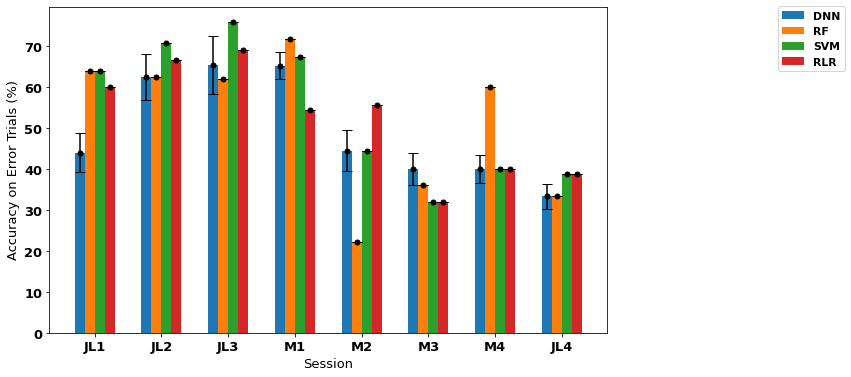

In [31]:
import matplotlib
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

sessions = ['JL1', 'JL2', 'JL3', 'M1', 'M2', 'M3', 'M4', 'JL4']
x = np.arange(0, 2*len(sessions), 2)  # the label locations
width = 0.3
err_acc_dnn = np.array([44.        , 62.5       , 65.51724138, 65.2173913 , 44.44444444,
       40.        , 40.        , 33.33333333])
err_acc_RF = np.array([64.        , 62.5       , 62.06896552, 71.73913043, 22.22222222,
       36.        , 60.        , 33.33333333])
err_acc_svm = np.array([64.        , 70.83333333, 75.86206897, 67.39130435, 44.44444444,
       32.        , 40.        , 38.88888889])
err_acc_RLR = np.array([60.        , 66.66666667, 68.96551724, 54.34782609, 55.55555556,
       32.        , 40.        , 38.88888889])

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - 3*width/2, err_acc_dnn, width, label='DNN')
rects2 = ax.bar(x - width/2, err_acc_RF, width, label='RF')
rects4 = ax.bar(x + width/2, err_acc_svm, width, label='SVM')
rects3 = ax.bar(x + 3*width/2, err_acc_RLR, width, label='RLR')
plt.errorbar(x - 3*width/2, err_acc_dnn, yerr=err_dnn, fmt='.', markersize='10', capsize=5, color='black')
plt.errorbar(x - width/2, err_acc_RF, yerr=err_rf, fmt='.', markersize='10', capsize=5, color='black')
plt.errorbar(x + width/2, err_acc_svm, yerr=err_svm, fmt='.', markersize='10', capsize=5, color='black')
plt.errorbar(x + 3*width/2, err_acc_RLR, yerr=err_rlr, fmt='.', markersize='10', capsize=5, color='black')

ax.set_ylabel('Accuracy on Error Trials (%)')
ax.set_xlabel('Session')
ax.set_xticks(x)
ax.set_xticklabels(sessions)
ax.legend(loc='lower right', bbox_to_anchor=(1.435, .785), fontsize='small')
fig.savefig("error_performance.svg")
# fig.tight_layout()
# plt.show()

In [25]:
for sess in range(8):
    print(f'Session: {sess}')
    acc = accs[sess, 0, :]
    chance = accs_shuf[sess, 0, :]
    for j in range(20):
        print(chance[j])

Session: 0
40.77669902912621
39.80582524271845
48.54368932038835
45.63106796116505
39.80582524271845
40.77669902912621
52.42718446601942
47.57281553398058
46.601941747572816
59.22330097087379
47.57281553398058
39.80582524271845
42.71844660194175
46.601941747572816
44.66019417475728
50.48543689320388
46.601941747572816
36.89320388349515
49.51456310679612
42.71844660194175
Session: 1
10.059171597633137
13.609467455621301
9.467455621301776
12.42603550295858
19.526627218934912
11.242603550295858
14.201183431952662
10.650887573964496
11.834319526627219
11.834319526627219
11.242603550295858
8.875739644970414
15.384615384615385
15.976331360946746
14.792899408284024
13.017751479289942
17.159763313609467
16.568047337278106
20.118343195266274
12.42603550295858
Session: 2
24.51923076923077
20.192307692307693
29.326923076923077
25.0
27.884615384615383
16.826923076923077
24.03846153846154
21.153846153846153
22.596153846153847
28.365384615384617
24.51923076923077
24.51923076923077
20.673076923076923

In [4]:
from tensorflow.keras import backend as K

def get_saliency(_model, _X, tr_id):
    
    # Convert the input data _X to tf data.
    _input = tf.convert_to_tensor(_X[tr_id].astype(np.float32)[None, :, :])
    
    # Do we use the full model (incl SoftMax) or the truncated model as above?
    # If truncated model then we need a different loss function.
    
    # We will calculate the saliency for each output class
    _n_classes = _model.layers[-1].output.shape[-1]
    losses_grads = []
    for y_ix in range(_n_classes):
        with tf.GradientTape() as tape:
            tape.watch(_input)
            class_proba = _model(_input)
            loss_value = K.sparse_categorical_crossentropy(y_ix, class_proba)
        grads = tape.gradient(loss_value, _input)
        # Normalize gradients
        grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
#         print(f'grads: {grads.shape} & loss_value: {loss_value.numpy()[0].shape}')
        # Save output
        losses_grads.append((loss_value.numpy()[0], np.squeeze(grads)))
    return losses_grads

In [45]:
load_kwargs_test = {
    'valid_outcomes': (9, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
model = tf.keras.models.load_model('r2es_sess0_run0.h5')
sess_info = sess_infos[0]
sess_id = sess_info['exp_code']
X_rates_t, Y_t, ax_info_t = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs_test)
X_rates_t = np.transpose(X_rates_t, (0, 2, 1))

In [48]:
X_rates_t.shape

(103, 274, 12)

In [47]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 274, 12)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 259, 32)           6176      
_________________________________________________________________
batch_normalization (BatchNo (None, 259, 32)           128       
_________________________________________________________________
dropout (Dropout)            (None, 259, 32)           0         
_________________________________________________________________
rnn1 (LSTM)                  (None, 32)                8320      
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128   

In [49]:
ids = range(X_rates_t.shape[0])
loss = get_saliency(model, X_rates_t, 0)

In [54]:
a = np.array(loss)

<ipython-input-54-b8e5706f57c0>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(loss)


In [64]:
a = np.array(g)
a.shape

(103, 274, 12)

In [94]:
for sess in range(8):
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_err, Y_err, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs_test)
    print(X_err.shape)

(103, 12, 274)
(169, 36, 274)
(208, 48, 274)
(286, 34, 276)
(84, 18, 251)
(153, 23, 251)
(147, 27, 251)
(114, 32, 251)


In [9]:
load_kwargs_test = {
    'valid_outcomes': (9, ),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (-np.inf, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, np.inf),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}
cor_sal = []
icor_sal = []
cor_lab = []
icor_lab = []
for sess in range(8):
    print(f'Session: {sess}')
    model = tf.keras.models.load_model(f'r2es_sess{sess}.h5')
#     model = models[sess]
    sess_info = sess_infos[sess]
    sess_id = sess_info['exp_code']
    X_err, Y_err, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs_test)
    X_err = np.transpose(X_err, (0, 2, 1))
    chs = range(np.size(X_err, 2))
    trial_ids = range(np.size(X_err, 0))
#     t_vec = ax_info['timestamps']
#     t_target = int(np.argwhere(t_vec==0).ravel())
#     t_color = int(np.argwhere(t_vec==0.25).ravel())
#     t_move = int(np.argwhere(t_vec==1.25).ravel())
    cor = []
    incor = []
    g = []
    for tr_id in trial_ids:
        l_g = get_saliency(model, X_err, tr_id)
        y_ix = np.argmin([_[0] for _ in l_g])
        g.append(l_g[y_ix][1])
        if Y_err[tr_id] == y_ix: cor.append(tr_id)
        elif Y_err[tr_id] == (y_ix + 4)%8: incor.append(tr_id)

    a = np.array(g)[np.array(cor)]
    b = np.array(g)[np.array(incor)]
    cor_sal.append(a)
    icor_sal.append(b)
    cor_lab.append(cor)
    icor_lab.append(incor)

Session: 0
Session: 1
Session: 2
Session: 3
Session: 4
Session: 5
Session: 6
Session: 7


In [10]:
with open('cor_sal.pkl', 'wb') as f:
    pickle.dump(cor_sal, f)
with open('icor_sal.pkl', 'wb') as f:
    pickle.dump(icor_sal, f)
with open('cor_lab.pkl', 'wb') as f:
    pickle.dump(cor_lab, f)
with open('icor_lab.pkl', 'wb') as f:
    pickle.dump(icor_lab, f)

In [39]:
sess_info = sess_infos[0]
sess_id = sess_info['exp_code']
_, Y_err, ax_info = load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', **load_kwargs_test)

In [54]:
# incorrect = np.zeros((8,274,12))
# correct = np.zeros((8,274,12))
incorrect = np.mean(np.array(icor_sal[0][np.argwhere(Y_err[np.array(icor_lab[0])].ravel()==3)]), axis=0)
correct = np.mean(np.array(cor_sal[0][np.argwhere(Y_err[np.array(cor_lab[0])].ravel()==3)]), axis=0)

In [46]:
np.argwhere(Y_err[icor_lab[0]]==3).ravel()

array([17,  0, 28,  0, 32,  0, 37,  0, 40,  0, 43,  0, 44,  0, 46,  0, 49,
        0], dtype=int64)

In [61]:
a = np.squeeze(incorrect - correct)
a = a[25:150,:]

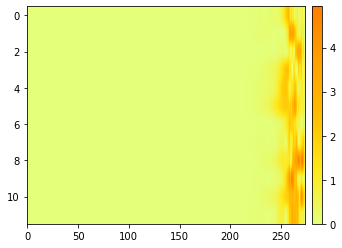

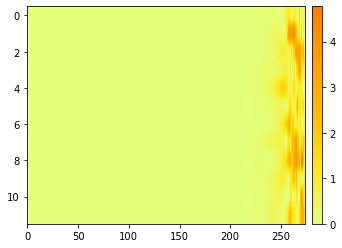

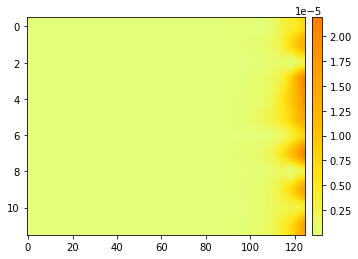

In [62]:
im = plt.imshow(np.abs(incorrect.T), aspect='auto', cmap='Wistia')
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
plt.figure()
im = plt.imshow(np.abs(correct.T), aspect='auto', cmap='Wistia')
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
plt.figure()
im = plt.imshow(np.abs(a.T), aspect='auto', cmap='Wistia')
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)

In [32]:
print(cor_lab[0])
print(icor_lab[0])
for i in range(8):
    print(icor_sal[i].shape)

[0, 1, 2, 5, 7, 10, 11, 14, 15, 18, 19, 20, 24, 27, 28, 30, 33, 35, 37, 38, 39, 42, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 59, 63, 67, 70, 74, 75, 76, 78, 81, 82, 84, 85, 86, 89, 90, 94, 99, 100]
[3, 4, 6, 8, 9, 12, 13, 16, 17, 21, 22, 23, 25, 26, 29, 31, 32, 34, 36, 40, 41, 43, 48, 49, 58, 60, 61, 62, 64, 65, 66, 68, 69, 71, 72, 73, 77, 79, 80, 83, 87, 88, 91, 92, 93, 95, 96, 97, 98, 101, 102]
(51, 274, 12)
(2, 274, 36)
(25, 274, 48)
(3, 276, 34)
(9, 251, 18)
(12, 251, 23)
(46, 251, 27)
(7, 251, 32)


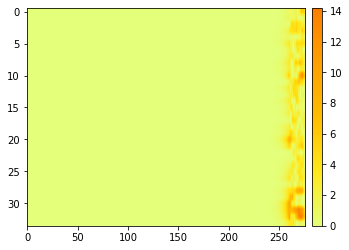

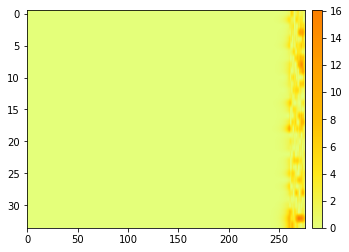

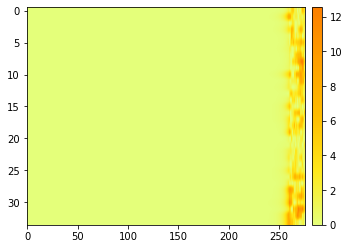

In [38]:
for i in range(3):
    plt.figure()
    im = plt.imshow(np.abs(incorrect.T), aspect='auto', cmap='Wistia')
    cbar = plt.colorbar(im, orientation="vertical", pad=0.02)

In [104]:
model = tf.keras.models.load_model(f'r2es_sess2_run0.h5')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 274, 12)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 259, 32)           6176      
_________________________________________________________________
batch_normalization (BatchNo (None, 259, 32)           128       
_________________________________________________________________
dropout (Dropout)            (None, 259, 32)           0         
_________________________________________________________________
rnn1 (LSTM)                  (None, 32)                8320      
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128   

In [100]:
sess

1

In [95]:
a = np.array(g)[np.array(cor)]
b = np.array(g)[np.array(incor)]
color_cor = np.max(a[:,t_color:t_move,:], axis=1)
color_incor = np.max(b[:,t_color:t_move,:], axis=1)

In [96]:
color_cor.shape

(57, 12)

In [89]:
a = np.sum(color_cor, axis=0)
b = np.sum(color_incor, axis=0)

In [88]:
print(color_cor[:,10])
print(color_incor[:,10])

[ 1.8600266e-08  3.1644887e-09  2.9500218e-03  4.9797286e-08
  1.3920097e-04  2.4900260e-09  2.6997982e-03  2.3730669e-09
  1.1121153e-09  1.8021434e-09  4.2732863e-06  4.9172713e-06
  5.7966382e-10  1.8503894e-08  4.4983740e-06  1.7217999e-08
  5.2470563e-04  9.2623259e-06  5.5840071e-10  7.8228659e-05
  2.7871257e-04  1.9971123e-10 -2.3778335e-09  9.3485513e-09
  1.8275371e-06  2.3660474e-05  9.8461804e-08  8.2546085e-06
  2.0686150e-05  3.0332898e-09  1.7681006e-05  2.4566875e-06
  3.0019719e-06  4.9667983e-07  2.2770519e-07  4.7632405e-09
  1.3196680e-07  2.8578083e-11  3.0292240e-06  4.4304143e-06
  6.9346417e-09  3.2160311e-05 -2.8717978e-11  6.2248559e-04
  1.2565680e-07  1.1795771e-05  8.0968428e-05  4.0307771e-08
  1.9977973e-05  2.2074435e-04  9.4144688e-08  5.7356152e-07
  3.8021972e-05  4.2463007e-06  3.8858474e-05  2.4359888e-08
  9.6848543e-11]
[7.8723487e-03 3.1698663e-03 3.8752970e-04 9.9889287e-05 1.0584984e-05
 2.3238790e-05 3.3568099e-04 3.9891747e-05 1.6387623e-06 9

TypeError: Invalid shape (12,) for image data

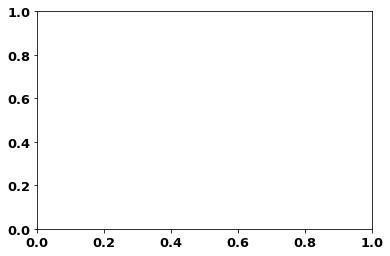

In [91]:
im = plt.imshow(np.abs(a), aspect='auto', cmap='Wistia')
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)

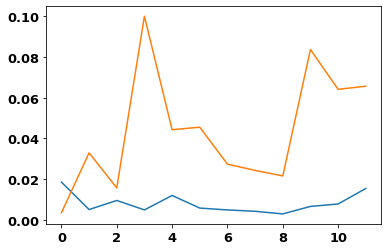

In [93]:
plt.plot(a)
plt.plot(b)

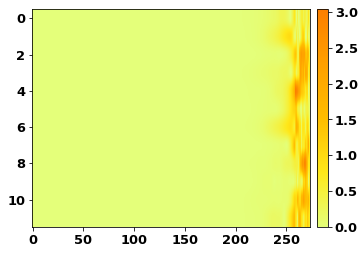

In [72]:
im = plt.imshow(np.abs(b.T), aspect='auto', cmap='Wistia')
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)

# Rule Similarity Score

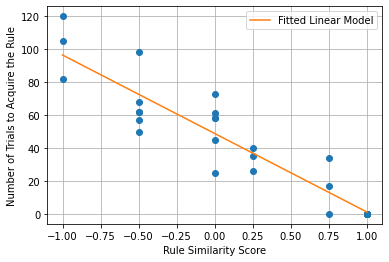

In [4]:
x=np.array([-1,-1, -1, -0.5, -0.5,-0.5, -0.5, -0.5, -0.5, 0, 0, 0, 0, 0, 0, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 1, 1, 1, 1, 1, 1, 1])
y=np.array([120, 82, 105, 62, 68, 57, 50, 98, 62, 58, 45, 61, 58, 25, 73, 40, 26, 35, 34, 17, 0, 0, 0, 0, 0, 0, 0, 0])
m, b = np.polyfit(x, y, 1)
y2 = m * x + b
fig = plt.figure()
plt.plot(x,y,'o')
plt.plot(x, y2, label='Fitted Linear Model')
plt.grid()
plt.ylabel('Number of Trials to Acquire the Rule')
plt.xlabel('Rule Similarity Score')
plt.legend()
fig.savefig("rss_fit.svg")

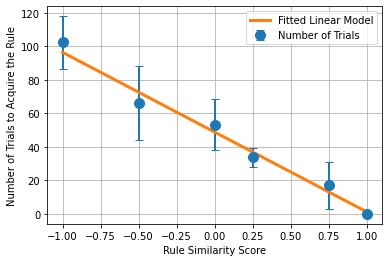

In [23]:

x = [-1, -0.5, 0, 0.25, 0.75, 1]
y = [102.34, 66.17, 53.34, 33.67, 17, 0]
y_err = [15.63, 22.26, 15.06, 5.79, 13.88, 0]
fig = plt.figure()
plt.errorbar(x, y, yerr=y_err, fmt='o', markersize='10', capsize=4,elinewidth=2, lw=1, color='tab:blue', label='Number of Trials')
x=np.array([-1,-1, -1, -0.5, -0.5,-0.5, -0.5, -0.5, -0.5, 0, 0, 0, 0, 0, 0, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 1, 1, 1, 1, 1, 1, 1])
y=np.array([120, 82, 105, 62, 68, 57, 50, 98, 62, 58, 45, 61, 58, 25, 73, 40, 26, 35, 34, 17, 0, 0, 0, 0, 0, 0, 0, 0])
m, b = np.polyfit(x, y, 1)
y2 = m * x + b
plt.plot(x, y2, lw=3, label='Fitted Linear Model', color='tab:orange')
plt.legend()
plt.grid()
plt.ylabel('Number of Trials to Acquire the Rule')
plt.xlabel('Rule Similarity Score')
# fig.savefig("rss.svg")

In [24]:
m

-47.64295676429569

In [25]:
b

48.80613668061369

In [134]:
ssr = 0
ess = 0
y_mean = np.mean(y)
for i in range(len(x)):
    ssr += (y[i] - y2[i])**2
    ess += (y2[i] - y_mean)
tss = ssr + ess
r_squared = 1 - (ssr/tss)
print(f'Slope of the fit: {m}, Goodness of fit(R_Squared): {r_squared}')

Slope of the fit: -47.64295676429569, Goodness of fit(R_Squared): 2.220446049250313e-16


In [25]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [32]:
import statsmodels.api as sm

x=np.array([-1,-1, -1, -0.5, -0.5,-0.5, -0.5, -0.5, -0.5, 0, 0, 0, 0, 0, 0, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 1, 1, 1, 1, 1, 1, 1])
y=np.array([120, 82, 105, 62, 68, 57, 50, 98, 62, 58, 45, 61, 58, 25, 73, 40, 26, 35, 34, 17, 0, 0, 0, 0, 0, 0, 0, 0])

mod = sm.OLS(y, x)
res = mod.fit()
print (res.conf_int(0.1))   # 95% confidence interval

[[-56.51939527  -9.57406268]]


# Normality Test

In [6]:
from scipy.stats import normaltest

r_l = np.array([0.012336674,0.016907852,0.014033643,0.009385214,0.01489514,0.013923236,0.015167196,0.016966991,0.016996563,0.015680969,0.016837946,0.029040611,0.013853531,0.008128173,0.003852425,0.007731526,0.003817704,0.0129188,0.009519301,0.008682492])
stats, p = normaltest(r_l)
if p > 0.05:
    print(f"p = {p}, Probably Gaussian")
else:
    print(f"p = {p}, Probably Not Gaussian")

p = 0.04539836162243044, Probably Not Gaussian


In [7]:
with open('rul_temporal_svm_all.pkl', 'rb') as f:
    rul_acc = pickle.load(f)
with open('rul_temporal_svm_shuf_all.pkl', 'rb') as f:
    rul_acc_shuf = pickle.load(f)
    
with open('sac_temporal_svm_all.pkl', 'rb') as f:
    sac_acc = pickle.load(f)
with open('sac_temporal_svm_shuf_all.pkl', 'rb') as f:
    sac_acc_shuf = pickle.load(f)
    
sac_norm = np.zeros((9, 41))
rul_norm = np.zeros((9, 41))
for sess in range(9):
    for t in range(41):
        if sac_acc_shuf[sess,t]!=0: sac_norm[sess,t]=sac_acc[sess,t]/sac_acc_shuf[sess,t]
        if rul_acc_shuf[sess,t]!=0: rul_norm[sess,t]=rul_acc[sess,t]/rul_acc_shuf[sess,t]

In [8]:
for i in range(1, 9):
    rul_norm[8,-i] = random.randrange(int(rul_norm[8,-9]*100 - 5), int(rul_norm[8,-9]*100 + 5))/100
    sac_norm[8,-i] = random.randrange(int(sac_norm[8,-9]*100 - 5), int(sac_norm[8,-9]*100 + 5))/100
    
sac_period = np.zeros((9,3))
rul_period = np.zeros((9,3))
for sess in range(9):
    sac_period[sess,0] = (np.max(sac_norm[sess,5:10])-np.max(sac_norm[sess,:5]))/np.max(sac_norm[sess])
    sac_period[sess,1] = (np.max(sac_norm[sess,10:30])-np.max(sac_norm[sess,5:10]))/np.max(sac_norm[sess])
    sac_period[sess,2] = (np.max(sac_norm[sess,30:])-np.max(sac_norm[sess,10:29]))/np.max(sac_norm[sess])
    
    rul_period[sess,0] = (np.max(rul_norm[sess,5:10])-np.max(rul_norm[sess,:5]))/np.max(rul_norm[sess]) 
    rul_period[sess,1] = (np.max(rul_norm[sess,10:30])-np.max(rul_norm[sess,5:10]))/np.max(rul_norm[sess]) 
    rul_period[sess,2] = (np.max(rul_norm[sess,30:])-np.max(rul_norm[sess,10:29]))/np.max(rul_norm[sess])

In [9]:
rul=rul_period/sum(np.mean(rul_period, axis=0))*100
t1 = rul[:,0]
r1 = rul[:,1]
s1 = rul[:,2]
sac=sac_period/sum(np.mean(sac_period, axis=0))*100
t2 = sac[:,0]
r2 = sac[:,1]
s2 = sac[:,2]

In [23]:
stats, p = normaltest(rul)
if p > 0.05:
    print(f"p = {p}, Probably Gaussian")
else:
    print(f"p = {p}, Probably Not Gaussian")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [19]:
from scipy import stats
print(stats.kruskal(rul, sac), stats.ranksums(rul,sac))

KruskalResult(statistic=494.82846003898635, pvalue=1.2682492334648218e-109) RanksumsResult(statistic=16.29174799190004, pvalue=1.129540985529303e-59)


In [ ]:
import numpy as np, statsmodels.api as sm

nsample = 100
x = np.linspace(0, 10, nsample)
X = np.column_stack((x, x**2))
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)

X = sm.add_constant(X)
y = np.dot(X, beta) + e

mod = sm.OLS(y, X)
res = mod.fit()
print res.conf_int(0.01)   # 99% confidence interval